# Car price prediction
**Project Description:** Prediction of car prices by car's characteristics. There is no training sample with correct answers. It must be found from external sources.

**Goal:** To identify cars whose price is below market.

**Objectives:** Create model to predict car prices.

**Dataset Description:** Dataset consists of 0 rows into train set and 3 637 rows into test set. It is necessary to parse train data from the internet.

Dataset features:

1. bodyType;
2. brand;
3. color;
4. fuelType;
5. modelDate;
6. name - model name;
7. numberOfDoors;
8. productionDate;
9. vehicleConfiguration;
10. vehicleTransmission;
11. engineDisplacement;
12. enginePower;
13. description;
14. mileage;
15. Комплектация - equipment;
16. Привод - drive unit;
17. Руль - left or right;
18. Состояние - needed for repair or not;
19. Владельцы - number of owners;
20. ПТС - is passport original or not;
21. Таможня - is car cleared or not;
22. Владение - time of car ownership.

# Work plan
1. Collect data from external sources.
2. Base (default) processing of features making the baseline.
3. Whole optimization of initial features (without feature engineering) with baseline settings.
4. Feature engineering + polynomial features + dummies.
5. Find optimum sample value to define usefull features.
6. Find usefull features for several estimator models.
7. Optimize hyperparameters for each model in the stack.
8. Optimize hyperparameters for meta model of the stack.

In [12]:
import os
import re
import math
import json
import statistics
from collections import Counter, defaultdict
from itertools import chain, combinations
from pprint import pprint

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from bs4 import BeautifulSoup
from tqdm import tqdm
from scipy.stats import ttest_ind
from sklearn.base import clone
from sklearn.metrics import SCORERS, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import f_classif, mutual_info_classif

pd.options.display.max_columns = 40

In [13]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/lib/kaggle/gcp.py
/kaggle/input/sf-dst-car-price/test.csv
/kaggle/input/sf-dst-car-price/sample_submission.csv
/kaggle/input/car-data-moskva/car_data_novosibirsk.csv
/kaggle/input/car-data-moskva/car_refs_moskva.csv
/kaggle/input/car-data-moskva/car_data_moskva.csv
/kaggle/input/car-data-moskva/car_refs_sochi.csv
/kaggle/input/car-data-moskva/car_data_irkutsk.csv
/kaggle/input/car-data-moskva/car_refs_novosibirsk.csv
/kaggle/input/car-data-moskva/car_refs_irkutsk.csv
/kaggle/input/car-data-moskva/car_data_ekaterinburg.csv
/kaggle/input/car-data-moskva/car_refs_ekaterinburg.csv
/kaggle/input/car-data-moskva/car_data_sochi.csv
/kaggle/input/car-price-prediction/train_test_score_vs_feature_number.csv
/kaggle/input/car-price-prediction/custom.css
/kaggle/input/car-price-prediction/__notebook__.ipynb
/kaggle/input/car-price-prediction/__results__.html
/kaggle/input/car-price-prediction/__output__.json
/kaggle/input/car-price-prediction/__notebook_source__.ipynb
/kaggle/input/car-pri

In [14]:
# Save requirements
!pip freeze > requirements.txt

In [15]:
# G L O B A L   C O N S T A N T S
# Random seed
RANDOM_SEED = 42
# Suffix for features with power of -1
MINUS_ONE_SUFFIX = '_1'
# Suffix for duplicated features in various feature category
DUPLICATE_SUFFIX = '_dup'
# Target feature
TARGET = 'price'
# ID feature
IDENT = 'id'
# Binary feature to separate train and test data
TRAIN = 'TRAIN'
# Feature of random numbers
RANDOM = 'RANDOM'
# Target metric
METRIC = 'MAPE'
# Problem type: 'Regression' or 'Classification'
PROBLEM = 'Regression'
# Data, kernel and working paths
PATH_DATA = '/kaggle/input/sf-dst-car-price/'
PATH_KERNEL = '/kaggle/input/car-price-prediction/'
PATH_WORKING = '/kaggle/working/'
# Flag of availability to drop rows
DROP_AVAL = False

# Data preparing
## Collecting and formating

In [16]:
def get_cars_refs(url_cars_list, max_pages_num):
    """Get list of car data URLs from URL of car table
    
    max_pages_num - maximum number of pages to request from table.
    If there is no some page number, it will pass to the next page number.
    """
    # Cycle over pages
    car_refs = []
    for page in range(1, max_pages_num + 1):
        # Do URL request
        response = requests.get(url_cars_list+str(page))
        
        # If response is normal
        if response.status_code == 200:
            # Print page number
            print(f'Page {page}')
            
            # Parse page and find requred references
            for car in BeautifulSoup(response.content, 'html.parser').find_all(
                class_="Link ListingItemTitle-module__link"
            ):
                # Add reference to list
                car_refs.append(car['href'])
    
    # Save result to file
    car_refs = pd.DataFrame(car_refs)
    car_refs.drop_duplicates(inplace=True, ignore_index=True)
    car_refs.to_csv('car_refs.csv', index=False)
    
    return car_refs


def get_cars_data(refs, max_pages_range=None):
    """Get cars' data from cars' URL"""
    # Create dataframe
    data = {
        'reference': [], 'bodyType': [], 'brand': [], 'color': [], 'fuelType': [],
        'modelDate': [], 'name': [], 'numberOfDoors': [], 'productionDate': [],
        'vehicleConfiguration': [], 'vehicleTransmission': [], 'engineDisplacement': [],
        'enginePower': [], 'description': [], 'mileage': [], 'Комплектация': [],
        'Привод': [], 'Руль': [], 'Состояние': [], 'Владельцы': [], 'ПТС': [],
        'Таможня': [], 'Владение': [], 'id': [], 'price': [],
    }
    
    # Cycle over references
    units_num = refs.index if max_pages_range == None \
        else range(37 * (max_pages_range[0]-1), 37 * max_pages_range[1])
    for i in units_num:
        # Print page number and save data
        if not (i % 37):
            print(f'Page {i//37 + 1}')
            pd.DataFrame(data).to_csv('car_data.csv', index=False)
        
        # Do URL request
        response = requests.get(refs.iat[i, 0])
        
        # If response is normal
        if response.status_code == 200:
            # Parse 'price'
            parse = BeautifulSoup(response.content, 'html.parser').find(
                class_="OfferPriceCaption__price"
            )
            if parse is not None:
                price = re.findall('\d+', parse.contents[0].replace('\xa0', ''))
                price = float(price[0]) if len(price) > 0 else None
                data['price'].append(price)
            
                # Fill 'reference'
                data['reference'].append(refs.iat[i, 0])

                # Fill absences
                data['modelDate'].append(None)
                data['numberOfDoors'].append(None)
                data['vehicleConfiguration'].append(None)
                data['description'].append(None)
                data['id'].append(None)

                # Parse 'brand', 'name'
                parse = BeautifulSoup(response.content, 'html.parser').find_all(
                    class_="Link Link_color_gray CardBreadcrumbs__itemText"
                )
                data['brand'].append(parse[0].contents[0].replace('\xa0', ' ')
                    if len(parse) > 0 else None)
                data['name'].append(parse[4].contents[0].replace('\xa0', ' ')
                    if len(parse) > 4 else None)

                # Parse
                cell_data = {'mileage': None, 'vehicleTransmission': None, 'Привод': None,
                             'Руль': None, 'Состояние': None, 'Владельцы': None, 'ПТС': None,
                             'Таможня': None, 'productionDate': None, 'bodyType': None,
                             'color': None, 'engineDisplacement': None, 'enginePower': None,
                             'fuelType': None, 'Владение': None}
                next_cell = None
                CardInfo = BeautifulSoup(response.content, 'html.parser') \
                    .find('ul', class_="CardInfo")
                if CardInfo is not None:
                    for parse in CardInfo.find_all(class_="CardInfo__cell"):
                        if next_cell == 'productionDate':
                            parse_ = parse.find(class_="Link Link_color_black")
                            if parse_ is not None:
                                cell_data[next_cell] = float(parse_.contents[0])
                        elif next_cell == 'mileage':
                            mileage = re.findall('\d+', parse.contents[0].replace('\xa0', ''))
                            mileage = float(mileage[0]) if len(mileage) > 0 else None
                            cell_data[next_cell] = mileage
                        elif next_cell == 'bodyType':
                            parse_ = parse.find(class_="Link Link_color_black")
                            if parse_ is not None:
                                cell_data[next_cell] = parse_.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'color':
                            parse_ = parse.find(class_="Link Link_color_black")
                            if parse_ is not None:
                                cell_data[next_cell] = parse_.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'engine':
                            parse_ = parse.find('div')
                            if parse_ is not None:
                                number_list = re.findall(
                                    '(\d\.?\d*) (л[\.с]*)', parse_.contents[0].replace('\xa0', ' ')
                                )
                                for number in number_list:
                                    if number[1] == 'л':
                                        cell_data['engineDisplacement'] = number[0] + ' LTR'
                                        break
                                for number in number_list:
                                    if number[1] == 'л.с.':
                                        cell_data['enginePower'] = number[0] + ' N12'
                                        break
                            parse_ = parse.find(class_="Link Link_color_black")
                            if parse_ is not None:
                                cell_data['fuelType'] = parse_.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'vehicleTransmission':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Привод':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Руль':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Состояние':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Владельцы':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'ПТС':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Таможня':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')
                        elif next_cell == 'Владение':
                            cell_data[next_cell] = parse.contents[0].replace('\xa0', ' ')

                        next_cell = None

                        if parse.contents[0] == 'год выпуска':
                            next_cell = 'productionDate'
                        elif parse.contents[0] == 'Пробег':
                            next_cell = 'mileage'
                        elif parse.contents[0] == 'Кузов':
                            next_cell = 'bodyType'
                        elif parse.contents[0] == 'Цвет':
                            next_cell = 'color'
                        elif parse.contents[0] == 'Двигатель':
                            next_cell = 'engine'
                        elif parse.contents[0] == 'Коробка':
                            next_cell = 'vehicleTransmission'
                        elif parse.contents[0] == 'Привод':
                            next_cell = 'Привод'
                        elif parse.contents[0] == 'Руль':
                            next_cell = 'Руль'
                        elif parse.contents[0] == 'Состояние':
                            next_cell = 'Состояние'
                        elif parse.contents[0] == 'Владельцы':
                            next_cell = 'Владельцы'
                        elif parse.contents[0] == 'ПТС':
                            next_cell = 'ПТС'
                        elif parse.contents[0] == 'Таможня':
                            next_cell = 'Таможня'
                        elif parse.contents[0] == 'Владение':
                            next_cell = 'Владение'

                for key, value in cell_data.items():
                    data[key].append(value)

                # Parse 'Комплектация'
                Complectation = []
                CardCompl = BeautifulSoup(response.content, 'html.parser') \
                    .find(class_="CardComplectation CardOfferBody__contentIsland")
                if CardCompl is not None:
                    for tag in CardCompl.find_all(class_="CardComplectation__itemName"):
                        Complectation.append({'name': tag.contents[0], 'values': []})
                    for i, tag in enumerate(CardCompl.find_all(class_="CardComplectation__itemContent")):
                        for tag_inner in tag.find_all(class_="CardComplectation__itemContentEl"):
                            Complectation[i]['values'].append(tag_inner.contents[0])
                    Complectation = [str(Complectation)]
                else:
                    Complectation = []
                data['Комплектация'].append(str(Complectation))
            
    # Save result to file
    data = pd.DataFrame(data)
    data.to_csv('car_data.csv', index=False)

    return data

In [17]:
def collect_data():
    """Read train and test datasets and join them"""
    # Datasets reading
    df_train = []
    df_train.append(pd.read_csv('/kaggle/input/car-data-moskva/car_data_moskva.csv'))
    df_train.append(pd.read_csv('/kaggle/input/car-data-moskva/car_data_novosibirsk.csv'))
    df_train.append(pd.read_csv('/kaggle/input/car-data-moskva/car_data_ekaterinburg.csv'))
    df_train.append(pd.read_csv('/kaggle/input/car-data-moskva/car_data_irkutsk.csv'))
    df_train.append(pd.read_csv('/kaggle/input/car-data-moskva/car_data_sochi.csv'))
    df_train = pd.concat(df_train, ignore_index=True)
    df_train.drop_duplicates(subset='reference', inplace=True, ignore_index=True)
    df_test = pd.read_csv(PATH_DATA+'test.csv')
    sample_submission = pd.read_csv(PATH_DATA+'sample_submission.csv')

    # Join train and test datasets
    df_train[TRAIN] = 1 # Train flag = 1
    df_test[TRAIN] = 0  # Train flag = 0
    df_test[TARGET] = 0 # Fill target variable of the test dataset with zeros
    df_test['reference'] = ''
    df_join = df_test.append(df_train, ignore_index=True)
    
    return (df_join, sample_submission)


def check_features_format(df):
    """Check format of dataframe features"""
    # Features to check
    cols_regex = {
        'name': '(?:^[\w\. ]+)?(?:\d\.\dd?(?:hyb)?|Electro) (?:AT|MT|AMT) \([\w\. ]+\)(?: 4WD)?',
        'engineDisplacement': '\d\.\d|undefined LTR',
        'enginePower': '\d+ N12',
        'Владельцы': '\d\s(?:владел(?:ец|ьца)|или более)',
        'Владение': '^(?:(\d{1,2}) (?:год|года|лет))?(?: и )?(?:(\d{1,2}) месяц(?:а|ев)?)?$',
    }

    # Check and print result
    for column, regex in cols_regex.items():
        a = df[column].str.match(regex).sum()
        b = df[column].count()
        print(f"'{column}' feature matches the regex format '{regex}' for {a} out of {b} rows")


def format_features(df):
    """Format dataset"""
    df.loc[(df[TRAIN] == 0) & (df['mileage'] == 1.00000e+06), 'mileage'] = 5.25e+05
    
    df.loc[df[TRAIN] == 1, 'productionDate'] = df.loc[df[TRAIN] == 1, 'productionDate'] - 1
    
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'внедорожник 5 дв.'), 'numberOfDoors'] = 5
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'кабриолет'), 'numberOfDoors'] = 2
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'компактвэн'), 'numberOfDoors'] = 5
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'купе'), 'numberOfDoors'] = 2
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'лифтбек'), 'numberOfDoors'] = 5
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'родстер'), 'numberOfDoors'] = 2
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'седан'), 'numberOfDoors'] = 4
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'седан 2 дв.'), 'numberOfDoors'] = 2
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'универсал 5 дв.'), 'numberOfDoors'] = 5
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'хэтчбек 3 дв.'), 'numberOfDoors'] = 3
    df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'хэтчбек 5 дв.'), 'numberOfDoors'] = 5
    
    df['fuelType'] = df['fuelType'].str.lower()
    df.loc[df['fuelType'] == 'бензин, газобаллонное оборудование', 'fuelType'] = 'бензин'
    df.loc[df['fuelType'] == 'электро', 'fuelType'] = 'гибрид'# ??????????????????
    
    df.loc[df['engineDisplacement'] == 'undefined LTR', 'engineDisplacement'] = '0.7 LTR'
    df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: np.nan if x is np.nan
        else float(re.findall('\d\.?\d*', x)[0]))
    
    df['enginePower'] = df['enginePower'].apply(lambda x: np.nan if x is np.nan
        else int(re.findall('\d+', x)[0]))
    
    df['Комплектация'] = df['Комплектация'].str.strip("[]").str.strip("'\"")
    df.loc[df[TRAIN] == 1, 'Комплектация'] = df.loc[df[TRAIN] == 1, 'Комплектация'] \
        .str.replace("'", '"')
    df.loc[df['Комплектация'] == '', 'Комплектация'] = '[]'
    df['Комплектация'] = pd.Series([str(set(chain.from_iterable([js['values']
        for js in json.loads(row)]))).replace("', '", '|')[2:-2] for row in df['Комплектация']])

    df['Владельцы'] = df['Владельцы'].apply(lambda x: np.nan if x is np.nan
        else int(re.findall('\d', x)[0]))
    
    regex = '^(?:(\d{1,2}) (?:год|года|лет))?(?: и )?(?:(\d{1,2}) месяц(?:а|ев)?)?$'
    df['Владение_year'] = df['Владение'].apply(lambda x: np.nan if x is np.nan
        else re.findall(regex, x)[0][0])
    df['Владение_month'] = df['Владение'].apply(lambda x: np.nan if x is np.nan
        else re.findall(regex, x)[0][1])
    df.loc[df['Владение_year'] == '', 'Владение_year'] = 0
    df.loc[df['Владение_month'] == '', 'Владение_month'] = 0
    df['Владение_year'] = df['Владение_year'].astype('float64')
    df['Владение_month'] = df['Владение_month'].astype('float64')
    df['Владение'] = 12*df['Владение_year'] + df['Владение_month']
    
    regex = '(^[\w\. ]+)?(?:\d\.\dd?(?:hyb)?|Electro) (?:AT|MT|AMT) \([\w\. ]+\)(?: 4WD)?'
    df['name'] = df['name'].str.extract(regex, expand=False)
    df.loc[df['name'].isna(), 'name'] = 'noName'
    df['xDrive'] = df['name'].str.contains('xDrive').astype('uint8')
    df['name'] = df['name'].str.replace('xDrive', '')
    df['name'] = df['name'].str.strip(' ')
    df['sDrive'] = df['name'].str.contains('sDrive').astype('uint8')
    df['name'] = df['name'].str.replace('sDrive', '')
    df['name'] = df['name'].str.strip(' ')
    df.loc[df['name'] == 'Competition Package', 'name'] = 'Competition'
    df.loc[df['name'] == 'Competition Pack', 'name'] = 'Competition'
    df['s_index'] = 0
    df['L_index'] = 0
    df['M_index'] = 0
    df.loc[df['name'].str.contains('\d'), 's_index'] = df.loc[df['name'].str.contains('\d'), 'name'].str.contains('s').astype('uint8')
    df.loc[df['name'].str.contains('\d'), 'L_index'] = df.loc[df['name'].str.contains('\d'), 'name'].str.contains('L').astype('uint8')
    df.loc[df['name'].str.contains('\d'), 'M_index'] = df.loc[df['name'].str.contains('\d'), 'name'].str.contains('M').astype('uint8')
    df.loc[df['name'].str.contains('\d'), 'xDrive'] = df.loc[df['name'].str.contains('\d'), 'name'].str.contains('x').astype('uint8')
    df.loc[df['name'].str.contains('\d'), 'name'] = df.loc[df['name'].str.contains('\d'), 'name'].str.replace('[idsxLM]', '')
    df.loc[df['name'] == 'CS', 'name'] = 'noName'
    df.loc[df['name'] == 'N42 316', 'name'] = '316'

## Feature engineering

In [18]:
def create_degree_1_features(df, distr_params):
    """Create -1 degree quantity features"""
    # Cycle over columns with distribution parameters
    for column, param in distr_params.items():
        # Set parameters
        if param is None:
            # Default parameters
            adder = abs(df[column[:-len(MINUS_ONE_SUFFIX)]].median())
            minmax = '_min'
        else:
            adder = param[1]
            minmax = param[0]
        
        # Calculate new features
        if minmax == '_min':
            df[column] = 1 / (df[column[:-len(MINUS_ONE_SUFFIX)]]
                              - df[column[:-len(MINUS_ONE_SUFFIX)]].min() + adder)
        elif minmax == '_max':
            df[column] = 1 / (df[column[:-len(MINUS_ONE_SUFFIX)]].max()
                              - df[column[:-len(MINUS_ONE_SUFFIX)]] + adder)
        else:
            raise ValueError


def create_new_features(df):
    """Create new features from existing"""
    # Create feature of random numbers
    rng = np.random.default_rng(RANDOM_SEED)
    df[RANDOM] = rng.integers(1000000, size=(df.shape[0]))
    
    # Create binary features for NaN's
    df['Владение_NaN'] = df['Владение'].isna().astype('uint8')
    
    # Create duplicate of categorical columns for either ordinal and/or quantity features
    df['Владельцы'+DUPLICATE_SUFFIX] = df['Владельцы']
    
    # Create -1 degree quantity features
    distr_params = { 'enginePower_1': ('_max', 0.489939655109564),
                     'mileage_1': ('_min', 6.270772e+04),
                     'productionDate_1': ('_max', 10.917066308480281),
                     'Владение_1': ('_min', 6.447245)}
    create_degree_1_features(df, distr_params)
    
    # Additional -1 degree feature
    df['enginePower_dup_1'] = 1 / (df['enginePower'] - df['enginePower'].min() + 21.027888)

## Deleting of useless features

In [19]:
def delete_useless_features(df):
    """Delete useless features and data (rows)"""
    df.drop(df.loc[(df[TRAIN] == 1) & (df['Руль'] != 'Левый')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['Состояние'] != 'Не требует ремонта')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['Таможня'] != 'Растаможен')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '140')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '315')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '316 Ecotronc')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '40e')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '435')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '524')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '525 X')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '635')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == 'S')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '733')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['name'] == '216')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['bodyType'] == 'купе-хардтоп')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['color'] == 'розовый')].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['productionDate'] < 1981)].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['enginePower'] < 90)].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['mileage'] > 5.5e+05)].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & (df['Владение'] > 300)].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & df['fuelType'].isna()].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & df['Владельцы'].isna()].index, inplace=True)
    df.drop(df.loc[(df[TRAIN] == 1) & df['ПТС'].isna()].index, inplace=True)
    
    df.drop([IDENT,
             'modelDate',
             'description',
             'vehicleConfiguration',
             'Владение_year',
             'Владение_month',
             'reference',
             'Руль',
             'Состояние',
             'Таможня',
             'brand',], axis=1, inplace=True)

## Parse data

In [20]:
# refs = []
# refs.append(get_cars_refs('https://auto.ru/moskva/cars/bmw/used/?output_type=table&year_from=1890&year_to=2005&page=', 99))
# refs.append(get_cars_refs('https://auto.ru/moskva/cars/bmw/used/?output_type=table&year_from=2006&year_to=2010&page=', 99))
# refs.append(get_cars_refs('https://auto.ru/moskva/cars/bmw/used/?output_type=table&year_from=2011&year_to=2015&page=', 99))
# refs.append(get_cars_refs('https://auto.ru/moskva/cars/bmw/used/?output_type=table&year_from=2016&year_to=2020&page=', 99))
# refs = pd.concat(refs, ignore_index=True)
# refs.drop_duplicates(inplace=True, ignore_index=True)
# refs.to_csv('car_refs_moskva.csv', index=False)

# refs = get_cars_refs('https://auto.ru/novosibirsk/cars/bmw/used/?output_type=table&page=', 99)
# refs.to_csv('car_refs_novosibirsk.csv', index=False)
# data = get_cars_data(refs)
# data.to_csv('car_data_novosibirsk.csv', index=False)

# refs = get_cars_refs('https://auto.ru/ekaterinburg/cars/bmw/used/?output_type=table&page=', 99)
# refs.to_csv('car_refs_ekaterinburg.csv', index=False)
# data = get_cars_data(refs)
# data.to_csv('car_data_ekaterinburg.csv', index=False)

# refs = get_cars_refs('https://auto.ru/sochi/cars/bmw/used/?output_type=table&page=', 99)
# refs.to_csv('car_refs_sochi.csv', index=False)
# data = get_cars_data(refs)
# data.to_csv('car_data_sochi.csv', index=False)

# refs = get_cars_refs('https://auto.ru/irkutsk/cars/bmw/used/?output_type=table&page=', 99)
# refs.to_csv('car_refs_irkutsk.csv', index=False)
# data = get_cars_data(refs)
# data.to_csv('car_data_irkutsk.csv', index=False)

## Receiving of general information

In [21]:
df, sample_submission = collect_data()
check_features_format(df)
format_features(df)
create_new_features(df)
delete_useless_features(df)

'name' feature matches the regex format '(?:^[\w\. ]+)?(?:\d\.\dd?(?:hyb)?|Electro) (?:AT|MT|AMT) \([\w\. ]+\)(?: 4WD)?' for 12253 out of 12253 rows
'engineDisplacement' feature matches the regex format '\d\.\d|undefined LTR' for 12248 out of 12248 rows
'enginePower' feature matches the regex format '\d+ N12' for 12248 out of 12248 rows
'Владельцы' feature matches the regex format '\d\s(?:владел(?:ец|ьца)|или более)' for 12251 out of 12251 rows
'Владение' feature matches the regex format '^(?:(\d{1,2}) (?:год|года|лет))?(?: и )?(?:(\d{1,2}) месяц(?:а|ев)?)?$' for 4789 out of 4789 rows


**Show general information of datasets**

In [22]:
df.loc[df[TRAIN] == 1].head()

,bodyType,color,fuelType,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,Комплектация,Привод,Владельцы,ПТС,Владение,TRAIN,price,xDrive,sDrive,s_index,L_index,M_index,RANDOM,Владение_NaN,Владельцы_dup,enginePower_1,mileage_1,productionDate_1,Владение_1,enginePower_dup_1
3837,седан,чёрный,дизель,730,4.0,2018.0,автоматическая,3.0,249.0,22000.0,Открытие багажника без помощи рук|Система помо...,полный,1.0,Оригинал,10.0,1,5500000.0,0,0,0,1,0,599426,0,1.0,0.002656,0.000012,0.083913,0.064736,0.004464
3838,внедорожник 5 дв.,белый,дизель,30,5.0,2017.0,автоматическая,3.0,249.0,16000.0,Голосовое управление|Система контроля за полос...,полный,1.0,Оригинал,27.0,1,4250000.0,0,0,0,0,0,959681,0,1.0,0.002656,0.000013,0.077417,0.030819,0.004464
3839,внедорожник 5 дв.,белый,бензин,35,5.0,2009.0,автоматическая,3.0,306.0,111000.0,t,полный,1.0,Оригинал,NaN,1,1330000.0,0,0,0,0,0,953148,1,1.0,0.003130,0.000006,0.047808,NaN,0.003558
3840,внедорожник 5 дв.,серый,дизель,30,5.0,2018.0,автоматическая,3.0,249.0,17146.0,"Система помощи при торможении (BAS, EBD)|Центр...",полный,1.0,Оригинал,NaN,1,4699000.0,0,0,0,0,0,871238,1,1.0,0.002656,0.000013,0.083913,NaN,0.004464
3841,внедорожник 5 дв.,чёрный,дизель,30,5.0,2019.0,автоматическая,3.0,249.0,3.0,Открытие багажника без помощи рук|Система помо...,полный,1.0,Оригинал,4.0,1,6878000.0,0,0,0,0,0,494063,0,1.0,0.002656,0.000016,0.091600,0.105851,0.004464


In [23]:
df.loc[df[TRAIN] == 0].head()

,bodyType,color,fuelType,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,Комплектация,Привод,Владельцы,ПТС,Владение,TRAIN,price,xDrive,sDrive,s_index,L_index,M_index,RANDOM,Владение_NaN,Владельцы_dup,enginePower_1,mileage_1,productionDate_1,Владение_1,enginePower_dup_1
0,седан,чёрный,дизель,520,4.0,2017.0,автоматическая,2.0,190.0,158836.0,Центральный замок|Иммобилайзер|Датчик света|Ко...,задний,1.0,Оригинал,NaN,0,0.0,0,0,0,0,0,89250,1,1.0,0.002296,0.000005,0.077417,NaN,0.006060
1,седан,белый,дизель,318,4.0,2019.0,автоматическая,2.0,150.0,10.0,"Система помощи при торможении (BAS, EBD)|Центр...",задний,1.0,Оригинал,NaN,0,0.0,0,0,0,0,0,773956,1,1.0,0.002103,0.000016,0.091600,NaN,0.007998
2,седан,синий,бензин,550,4.0,2012.0,автоматическая,4.4,407.0,120000.0,Открытие багажника без помощи рук|Голосовое уп...,полный,2.0,Оригинал,86.0,0,0.0,0,0,0,0,0,654571,0,2.0,0.004577,0.000005,0.055813,0.010935,0.002618
3,внедорожник 5 дв.,белый,дизель,30,5.0,2015.0,автоматическая,3.0,249.0,111466.0,Центральный замок|Иммобилайзер|Датчик света|Ко...,полный,2.0,Оригинал,NaN,0,0.0,0,0,0,0,0,438878,1,2.0,0.002656,0.000006,0.067037,NaN,0.004464
4,внедорожник 5 дв.,синий,дизель,50,5.0,2019.0,автоматическая,3.0,381.0,11891.0,Центральный замок|Иммобилайзер|Память передних...,полный,1.0,Оригинал,NaN,0,0.0,0,0,0,0,1,433015,1,1.0,0.004090,0.000013,0.091600,NaN,0.002809


In [24]:
sample_submission.head()

,id,price
0,0,5299000.0
1,1,1580000.0
2,2,2000000.0
3,3,2199000.0
4,4,935000.0


In [25]:
df.loc[df[TRAIN] == 1].info()
print()
df.loc[df[TRAIN] == 0].info()
print()
df.info()
print()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8325 entries, 3837 to 12252
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             8325 non-null   object 
 1   color                8325 non-null   object 
 2   fuelType             8325 non-null   object 
 3   name                 8325 non-null   object 
 4   numberOfDoors        8325 non-null   float64
 5   productionDate       8325 non-null   float64
 6   vehicleTransmission  8325 non-null   object 
 7   engineDisplacement   8325 non-null   float64
 8   enginePower          8325 non-null   float64
 9   mileage              8325 non-null   float64
 10  Комплектация         8325 non-null   object 
 11  Привод               8325 non-null   object 
 12  Владельцы            8325 non-null   float64
 13  ПТС                  8325 non-null   object 
 14  Владение             3002 non-null   float64
 15  TRAIN                8325 non-null

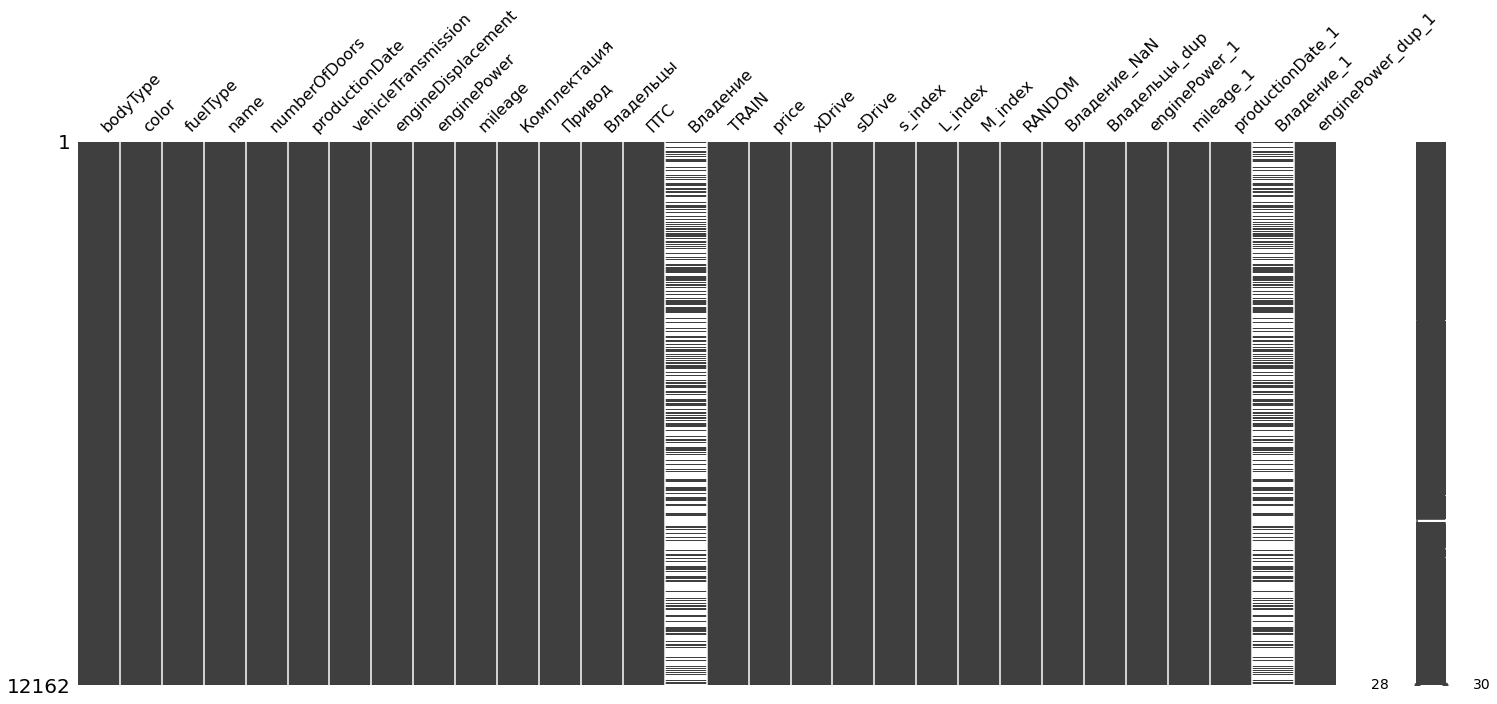

In [26]:
msno.matrix(df);

**Declare target variable, quantity, ordinal and categorical features**

In [27]:
def declare_features_type():
    """Declare target variable, quantity, ordinal and categorical features"""
    global categ_bin_cols, categ_many_cols, categ_multi_cols, categ_cols
    global quantity_cols, quantity_categ_cols, ordinal_cols
    
    # Declare categorical features
    categ_bin_cols = [
        'ПТС',
        'xDrive',
        'sDrive',
        's_index',
        'L_index',
        'M_index',
        'Владение_NaN',
    ]
    categ_many_cols = [
        'bodyType',
        'color',
        'fuelType',
        'name',
        'vehicleTransmission',
        'Привод',
        'Владельцы'+DUPLICATE_SUFFIX,
    ]
    categ_multi_cols = [
        'Комплектация',
    ]

    # Declare quantity features
    quantity_cols = [
        RANDOM,
        'numberOfDoors',
        'productionDate',
        'engineDisplacement',
        'enginePower',
        'mileage',
        'Владельцы',
        'Владение',

        'productionDate'+MINUS_ONE_SUFFIX,
        'enginePower'+MINUS_ONE_SUFFIX,
        'enginePower'+DUPLICATE_SUFFIX+MINUS_ONE_SUFFIX,
        'mileage'+MINUS_ONE_SUFFIX,
        'Владение'+MINUS_ONE_SUFFIX,
    ]

    # Declare categorized quantity features
    quantity_categ_cols = [
    ]

    # Declare ordinal features
    ordinal_cols = [
    ]

    # Update quantity, ordinal and categorical feature lists
    categ_bin_cols = [col for col in categ_bin_cols if col in df.columns]
    categ_many_cols = [col for col in categ_many_cols if col in df.columns]
    categ_multi_cols = [col for col in categ_multi_cols if col in df.columns]
    categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
    quantity_cols = [col for col in quantity_cols if col in df.columns]
    quantity_categ_cols = [col for col in quantity_categ_cols if col in df.columns]
    ordinal_cols = [col for col in ordinal_cols if col in df.columns]
    
declare_features_type()

**View unique values**

In [28]:
# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Find and show number of unique values of categorical features
categorical_unique_test = {}
categorical_unique_train = {}
categorical_unique = {}
for column in categ_cols:
    # Handle categ_multi_cols features
    if column in categ_multi_cols:
        categorical_unique_test[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & (df[TRAIN] == 0), column].str.split('|')))).sort_values(ascending=False)
        categorical_unique_train[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & (df[TRAIN] == 1), column].str.split('|')))).sort_values(ascending=False)
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].str.split('|')))).sort_values(ascending=False)

    # Handle categ_bin_cols and categ_many_cols features
    else:
        categorical_unique_test[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & (df[TRAIN] == 0), column].apply(lambda x: [x])))).sort_values(ascending=False)
        categorical_unique_train[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & (df[TRAIN] == 1), column].apply(lambda x: [x])))).sort_values(ascending=False)
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].apply(lambda x: [x])))).sort_values(ascending=False)

    # Show result
    print((column + ':').ljust(22)
          + str(len(categorical_unique_test[column])).rjust(8)
          + str(len(categorical_unique_train[column])).rjust(8)
          + str(len(categorical_unique[column])).rjust(8))

                         Test:  Train:    All:
ПТС:                         2       2       2
xDrive:                      2       2       2
sDrive:                      2       2       2
s_index:                     2       2       2
L_index:                     2       2       2
M_index:                     2       2       2
Владение_NaN:                2       2       2
bodyType:                   11      11      11
color:                      15      15      15
fuelType:                    3       3       3
name:                       65      65      66
vehicleTransmission:         3       3       3
Привод:                      3       3       3
Владельцы_dup:               3       3       3
Комплектация:              170     176     178


In [29]:
# Parameters
ALPHABET_ORDER = False

# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Show unique values of categorical features
for column in categ_cols:
    print(column + ':')
    for i in categorical_unique[column].sort_index().index if ALPHABET_ORDER \
      else categorical_unique[column].index:
        print(str(i).ljust(22), end='')
        if i in categorical_unique_test[column].index:
            print(str(categorical_unique_test[column].at[i]).rjust(8), end='')
        else:
            print(str(0).rjust(8), end='')
        if i in categorical_unique_train[column].index:
            print(str(categorical_unique_train[column].at[i]).rjust(8), end='')
        else:
            print(str(0).rjust(8), end='')
        print(str(categorical_unique[column].at[i]).rjust(8))
    print()

                         Test:  Train:    All:
ПТС:
Оригинал                  3463    6862   10325
Дубликат                   374    1463    1837

xDrive:
0                         3762    8132   11894
1                           75     193     268

sDrive:
0                         3825    8307   12132
1                           12      18      30

s_index:
0                         3791    8168   11959
1                           46     157     203

L_index:
0                         3666    7996   11662
1                          171     329     500

M_index:
0                         3778    8219   11997
1                           59     106     165

Владение_NaN:
1                         2084    5323    7407
0                         1753    3002    4755

bodyType:
седан                     1594    3943    5537
внедорожник 5 дв.         1626    3206    4832
купе                       214     385     599
хэтчбек 5 дв.              163     310     473
лифтбек                    1

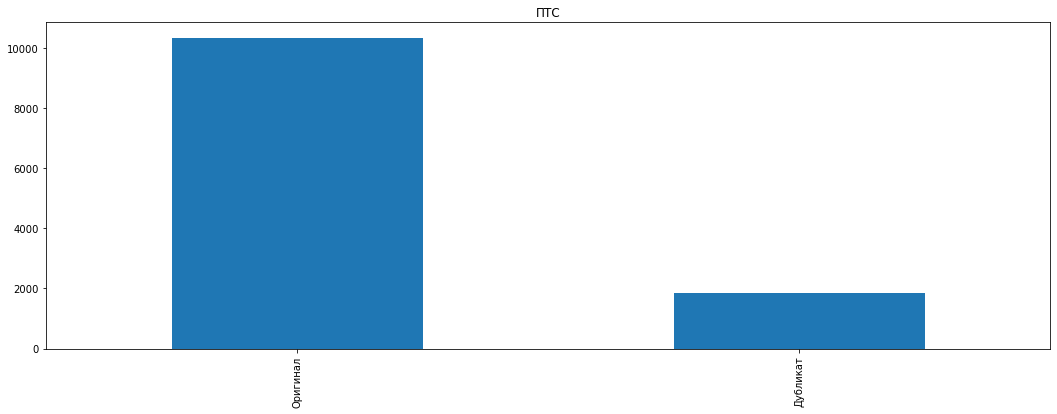

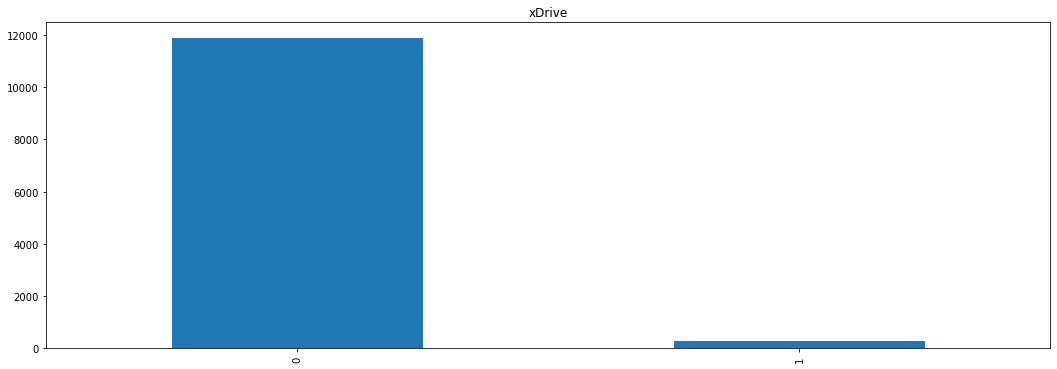

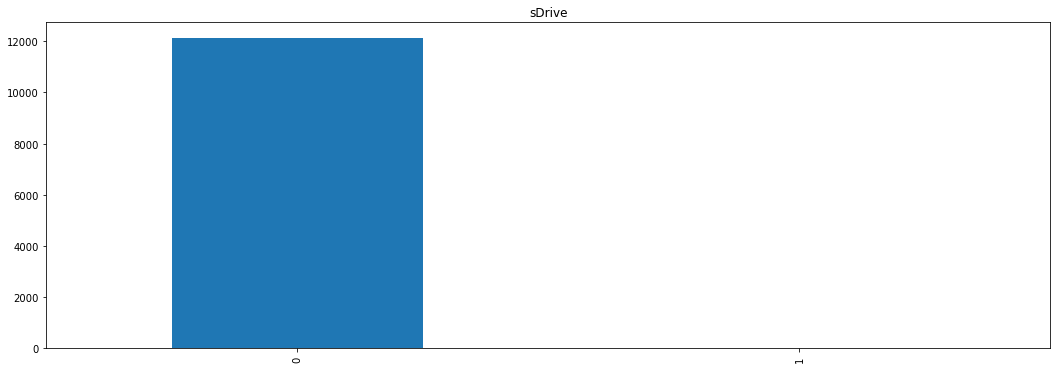

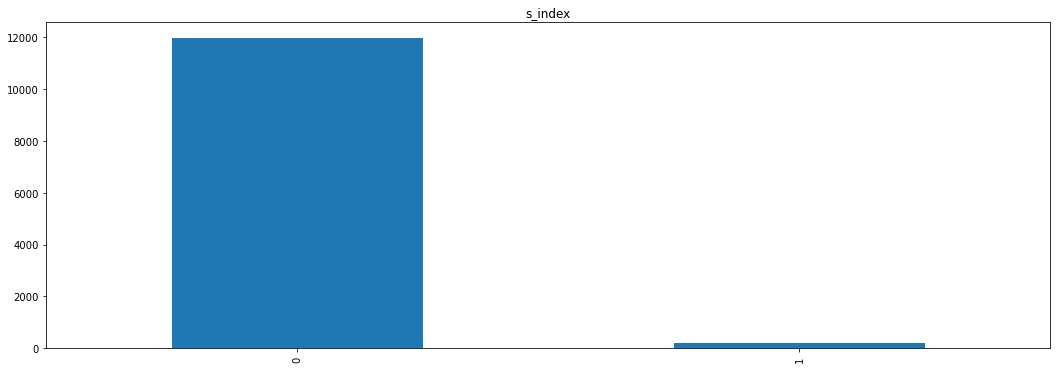

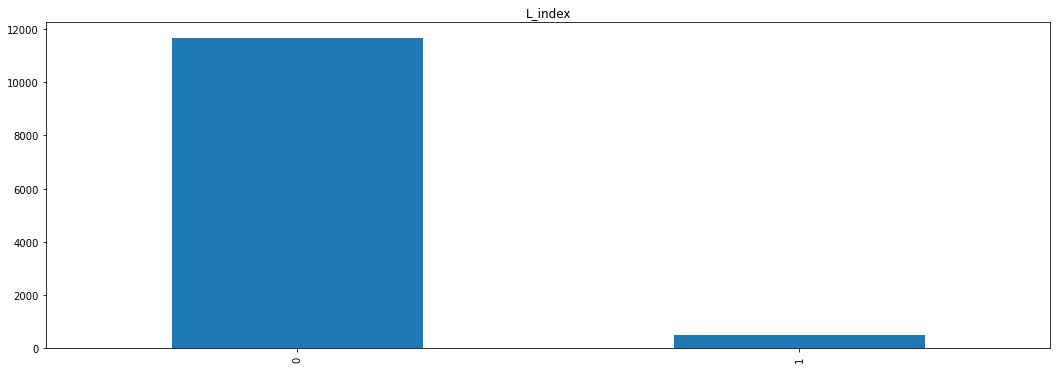

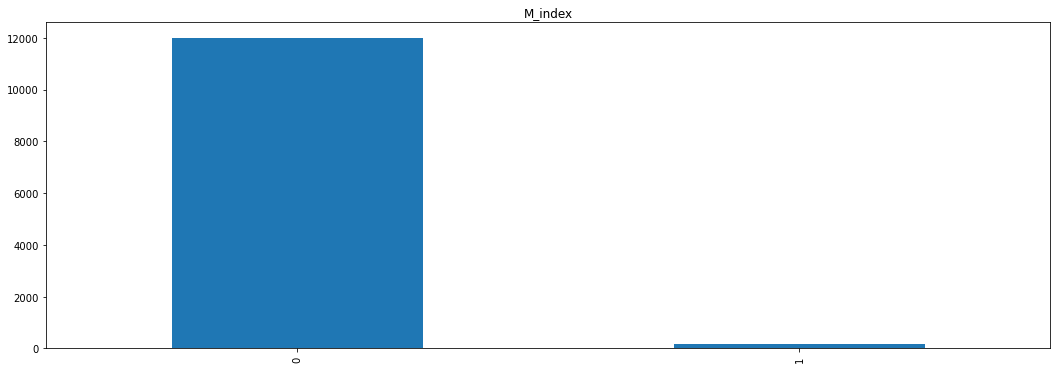

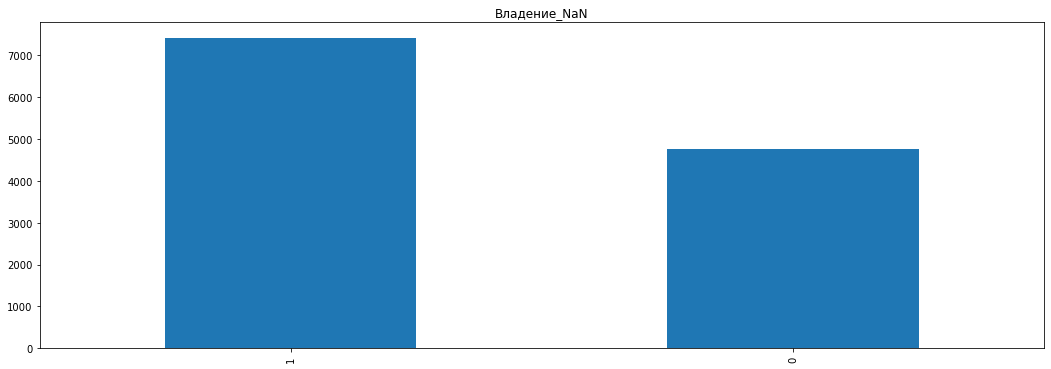

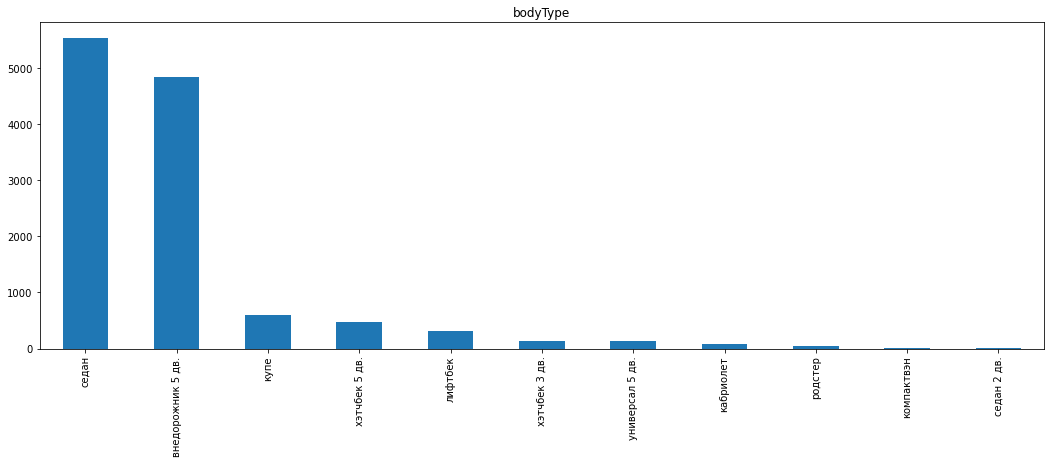

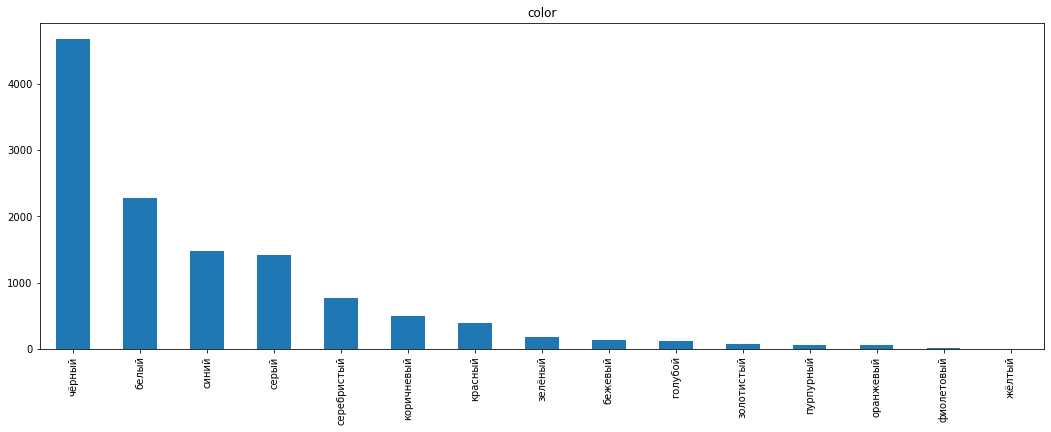

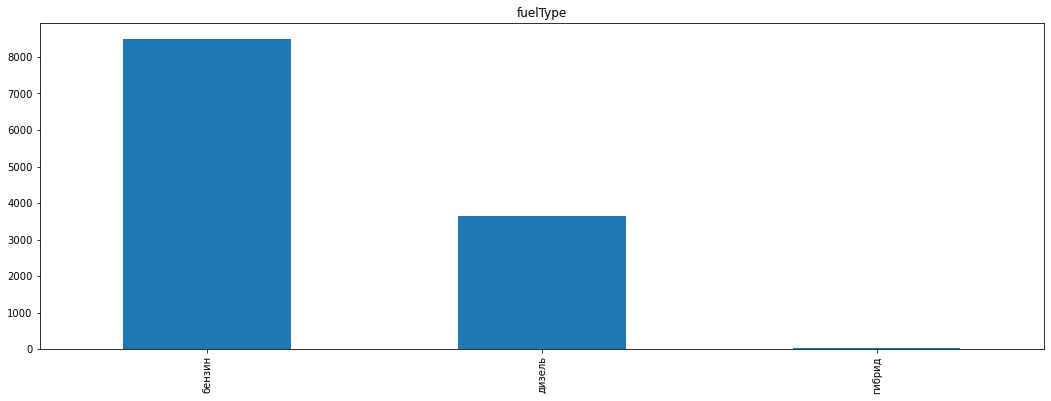

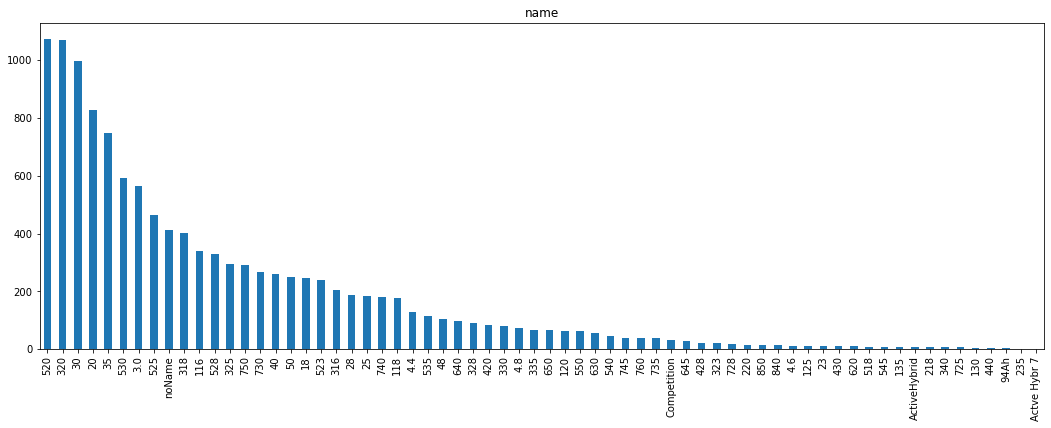

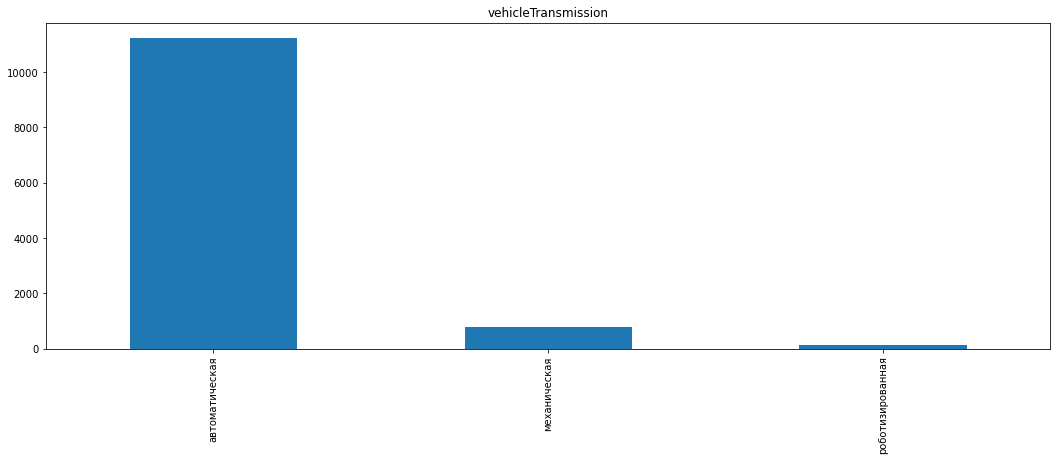

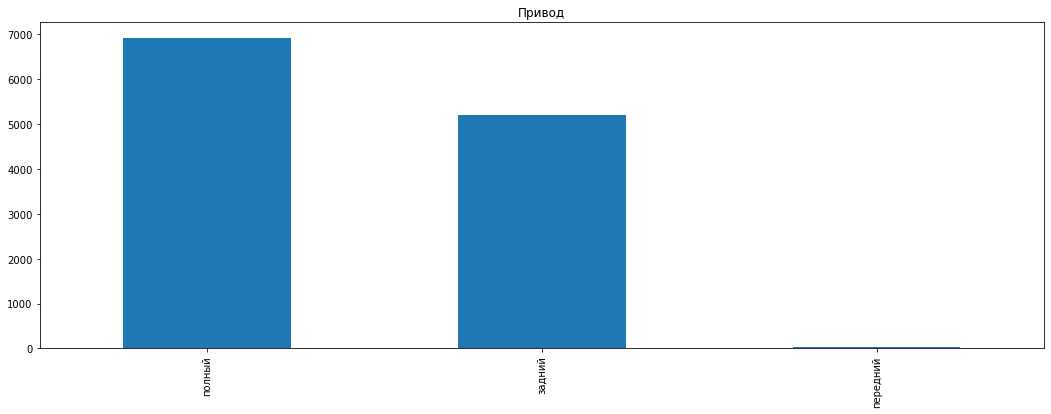

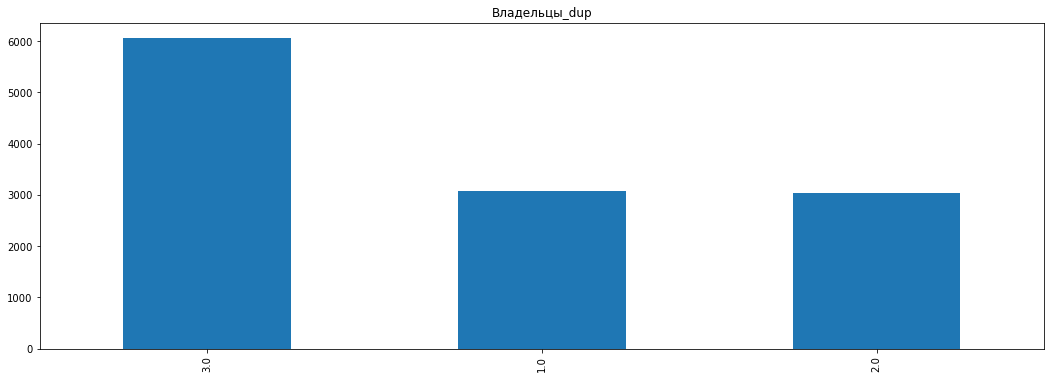

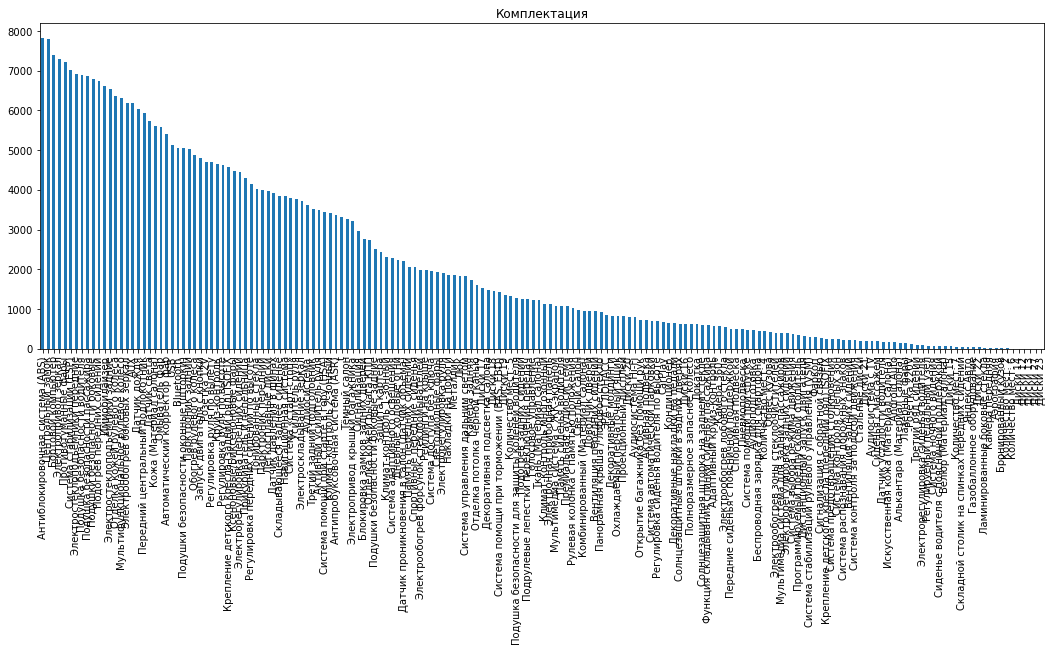

In [30]:
# Show distribution of categorical features
for column in categ_cols:
    categorical_unique[column].plot.bar(figsize=(18, 6), title=column)
    plt.show()

In [31]:
# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Show number of unique values of quantity and ordinal features
for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    print((column + ':').ljust(22)
          + (str(df.loc[df[TRAIN] == 0, column].nunique()).rjust(8))
          + (str(df.loc[df[TRAIN] == 1, column].nunique()).rjust(8))
          + (str(df[column].nunique()).rjust(8)))

                         Test:  Train:    All:
RANDOM:                   3830    8289   12085
numberOfDoors:               4       4       4
productionDate:             37      39      39
engineDisplacement:         22      27      27
enginePower:                75      77      82
mileage:                  1942    2620    4053
Владельцы:                   3       3       3
Владение:                  157     191     202
productionDate_1:           37      39      39
enginePower_1:              75      77      82
enginePower_dup_1:          75      77      82
mileage_1:                1942    2620    4053
Владение_1:                157     191     202


In [32]:
# Show unique values of quantity and ordinal features
columns = [ 'numberOfDoors',
            'productionDate',
            'engineDisplacement',
            'enginePower',
            'mileage',
            'Владельцы',
            'Владение',]

for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    if column in columns:
        print(('Test:  ' + column + ':').ljust(22), end='')
        print(np.sort(df.loc[df[TRAIN] == 0, column].unique()))
        print(('Train: ' + column + ':').ljust(22), end='')
        print(np.sort(df.loc[df[TRAIN] == 1, column].unique()))
        print(('All:   ' + column + ':').ljust(22), end='')
        print(np.sort(df[column].unique()))
        print()

Test:  numberOfDoors: [2. 3. 4. 5.]
Train: numberOfDoors: [2. 3. 4. 5.]
All:   numberOfDoors: [2. 3. 4. 5.]

Test:  productionDate:[1981. 1982. 1984. 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994.
 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006.
 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018.
 2019.]
Train: productionDate:[1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992.
 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004.
 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016.
 2017. 2018. 2019.]
All:   productionDate:[1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992.
 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004.
 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016.
 2017. 2018. 2019.]

Test:  engineDisplacement:[0.7 1.5 1.6 1.8 1.9 2.  2.2 2.5 2.8 2.9 3.  3.4 3.5 3.6 4.  4.4 4.6 4.8
 5.  5.4 6.  6.6]
Tr

## Visualization

In [33]:
def show_boxplots(df, show_target=False):
    """Show boxplots of quantity and ordinal features and check them for outliers existance"""
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 5
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].boxplot(df.loc[df[column].notna(), column], showmeans=True)
        axs[idx].set_title(column)
        

def show_histograms(df, show_target=False):
    """Show distributions of quantity and ordinal features"""
    # Parameters
    DEFAULT_BINS = 50
    
    # Fill the list of bins' step if know it
    bin_step = {
        'numberOfDoors': 1,
        'productionDate': 1,
        'Владельцы': 1,
    }
    
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil(len(columns)/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        # Calculate indices of subplots
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)

        # Calculate number of bins and ranges
        if column in bin_step.keys():
            col_max = df[column].max()
            col_min = df[column].min()
            step = bin_step[column]
            offset = step / 2
            bins = int((col_max-col_min) / step) + 1
            range_ = (col_min - offset, col_max + offset)
        elif column in ordinal_cols:
            col_max = df[column].max()
            col_min = df[column].min()
            bins = int((col_max-col_min) * 2) + 1
            range_ = (col_min - 0.25, col_max + 0.25)
        else:
            bins = DEFAULT_BINS
            range_ = None

        # Plot
        axs[idx].hist(df.loc[df[column].notna(), column], bins, range_)
        axs[idx].set_title(column)
        
        
def show_scatters(df, point_size=None):
    """Show scatter plots of quantity and ordinal features from TARGET"""
    # Define columns to plot
    columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].scatter(x=df.loc[df[column].notna() & (df[TRAIN] == 1), column],
                         y=df.loc[df[column].notna() & (df[TRAIN] == 1), TARGET],
                         s=point_size)
        axs[idx].set_title(column)
        

def show_CQF_boxplots(df):
    """Show boxplots of categorized quantity features"""
    NUM_OF_VALS = 10
    CATEGORY = 'feature_name'

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    categ_mask = {}
    top_categ_values = {}
    for i, column in enumerate(quantity_categ_cols):
        # Find masks
        categ_mask = {}
        top_categ_values = {}
        for column in quantity_categ_cols:
            # Find top NUM_OF_VALS values categorical feature
            top_categ_values[column] = categorical_unique[CATEGORY].index[:NUM_OF_VALS]

            # Find boolean masks
            categ_mask[column] = {}
            for value in top_categ_values[column]:
                categ_mask[column][value] = df[CATEGORY].str.contains(value)

        # Plot graphs
        if rows == 1:
            axs.boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_categ_values[column], rotation=5)
        else:
            axs[i].boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_categ_values[column], rotation=5)
            
    return (top_categ_values, categ_mask)
            
            
def show_CQF_histograms(df, top_categ_values, categ_mask):
    """Show distributions of categorized quantity features"""
    BINS = 100

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    for i, column in enumerate(quantity_categ_cols):
        # Plot graphs
        if rows == 1:
            for value in top_categ_values[column]:
                axs.hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs.set_title(column)
        else:
            for value in top_categ_values[column]:
                axs[i].hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs[i].set_title(column)

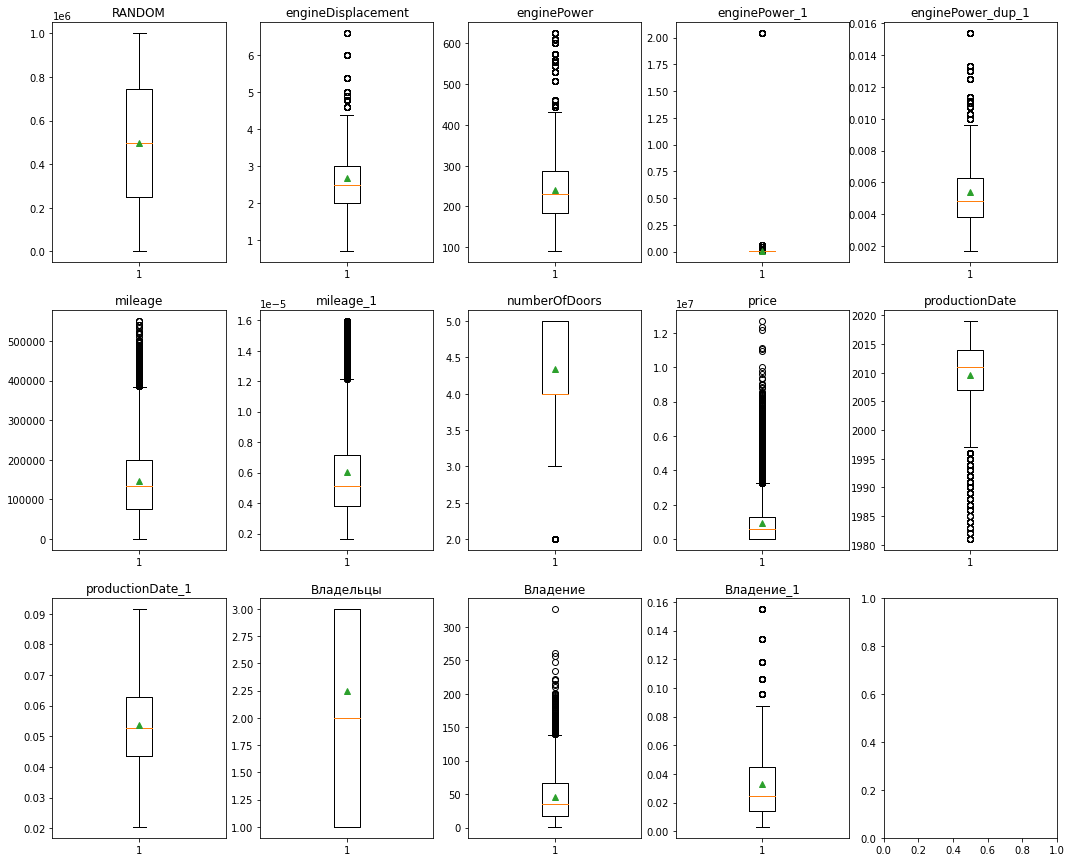

In [34]:
show_boxplots(df, show_target=True)

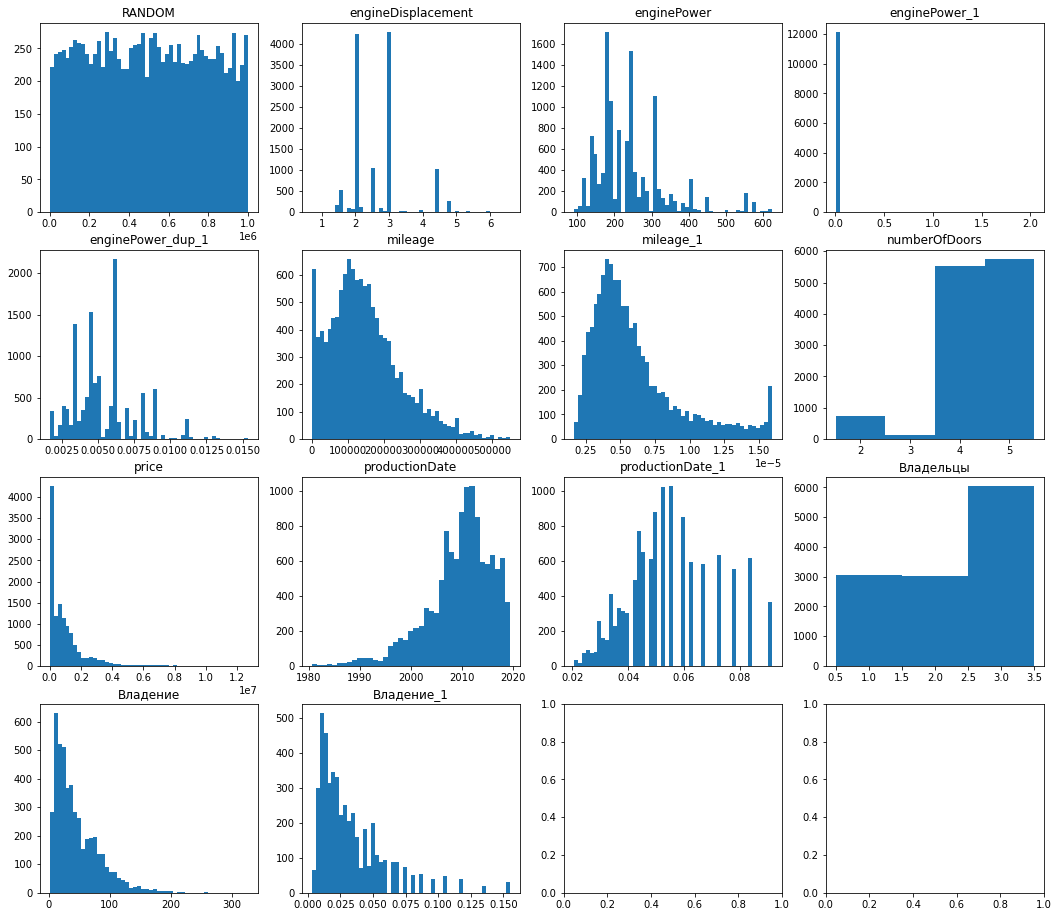

In [35]:
show_histograms(df, show_target=True)

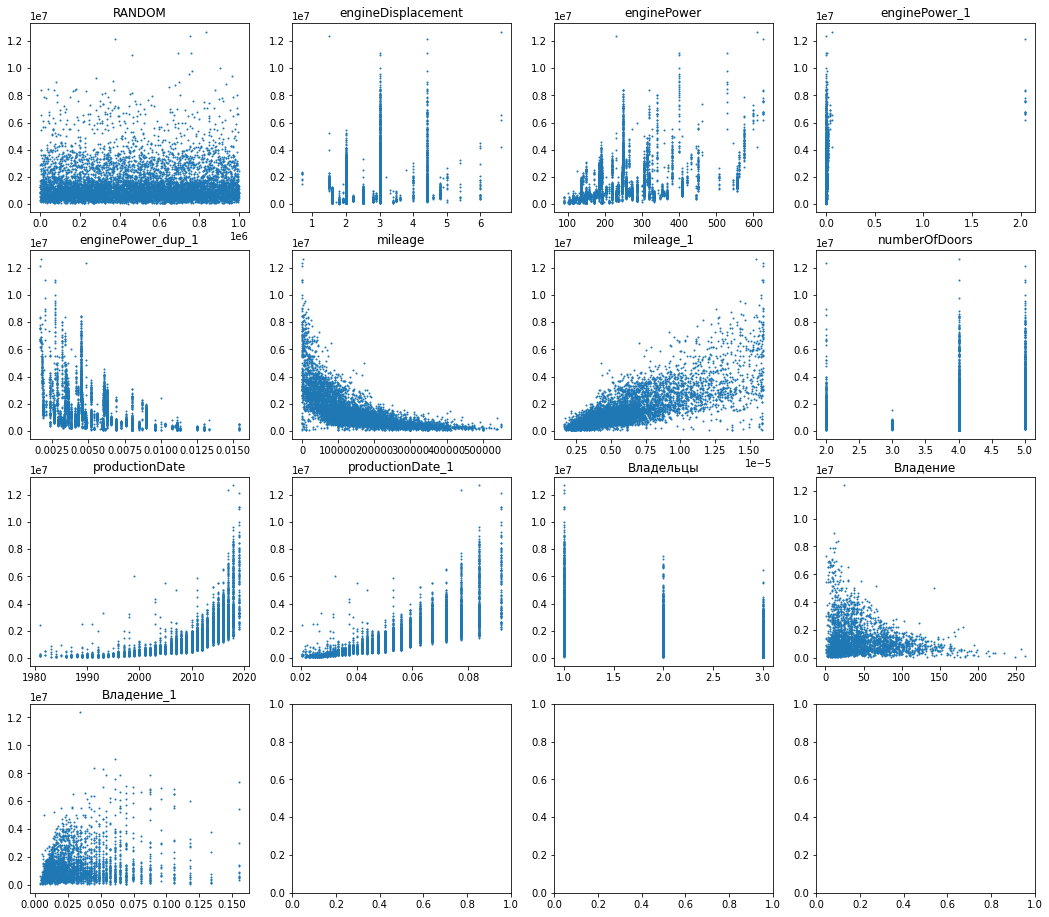

In [36]:
show_scatters(df, point_size=1)

## Outliers handling

In [37]:
def delete_outliers(df, inplace=False):
    """Show number of outliers and delete rows with outliers"""
    # Define columns to show graphs
    columns = sorted(quantity_cols).copy()
    
    # Exclude some columns from the process
    cols = [

    ]
    for col in df.columns:
        if col in cols:
            columns.remove(col)
    
    idx_dict = {}
    for column in columns:
        # Calculate Q1, Q3, IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate indices of rows
        idx_dict[column] = list(df.loc[(~df[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)) & (df[column].notna()), column].index)

        # Show the result
        outliers_num = len(idx_dict[column])
        if outliers_num:
            print(f"{str(outliers_num).rjust(6)} outliers are in column '{column}'")
            
    # Union indices
    idx = set()
    for column in columns:
        idx.update(idx_dict[column])

    # Drop rows with outliers
    if inplace:
        df.drop(idx, inplace=True)
        print(f"{str(len(idx)).rjust(6)} rows have been dropped")

In [38]:
# Show or delete outliers
print('train:')
delete_outliers(df.loc[df[TRAIN] == 1], inplace=DROP_AVAL)
print('test:')
delete_outliers(df.loc[df[TRAIN] == 0], inplace=DROP_AVAL)
print('join:')
delete_outliers(df, inplace=DROP_AVAL)

train:
   258 outliers are in column 'engineDisplacement'
   349 outliers are in column 'enginePower'
   703 outliers are in column 'enginePower_1'
   333 outliers are in column 'enginePower_dup_1'
   125 outliers are in column 'mileage'
   618 outliers are in column 'mileage_1'
   486 outliers are in column 'numberOfDoors'
   230 outliers are in column 'productionDate'
   106 outliers are in column 'productionDate_1'
    91 outliers are in column 'Владение'
   120 outliers are in column 'Владение_1'
test:
    86 outliers are in column 'engineDisplacement'
   280 outliers are in column 'enginePower'
   395 outliers are in column 'enginePower_1'
    84 outliers are in column 'enginePower_dup_1'
   109 outliers are in column 'mileage'
   281 outliers are in column 'mileage_1'
   244 outliers are in column 'numberOfDoors'
   130 outliers are in column 'productionDate'
    29 outliers are in column 'Владение'
    98 outliers are in column 'Владение_1'
join:
   344 outliers are in column 'e

## Form -1 degree features
### Distribution optimization is based on ANOVA analysis

In [39]:
def anova_analysis(df):
    """Calculate and show significance of quantity and ordinal features based on ANOVA analysis"""
    columns = quantity_cols + ordinal_cols
    df_temp = df.loc[df[TRAIN] == 1, columns + [TARGET]].dropna()
    return pd.Series(f_classif(df_temp[columns], df_temp[TARGET])[0], index=columns)


def calc_anova_optimum_distribution(df, columns):
    """Find best distribution parameters with help of ANOVA
    
    columns - column names with existing of MINUS_ONE_SUFFIX.
    """
    # Parameters
    START = 0.0001 # Parts of median
    STOP = 10     # Parts of median
    POINTS = 50   # Number of points between START and STOP

    # Reset columns' values
    df_temp = pd.DataFrame()
    for column in columns:
        df_temp[column+MINUS_ONE_SUFFIX] = df[column+MINUS_ONE_SUFFIX].copy()
        df[column+MINUS_ONE_SUFFIX] = 1 / (df[column] - df[column].min() + abs(df[column].median()))

    # Cycle over columns
    param_dict = {}
    result_dict = {}
    for column in columns:
        # Cycle over distribution adders
        max_anova = 0
        param_dict[column+MINUS_ONE_SUFFIX+'_adder'] = []
        param_dict[column+MINUS_ONE_SUFFIX+'_min'] = []
        param_dict[column+MINUS_ONE_SUFFIX+'_max'] = []
        for i in np.geomspace(start=START, stop=STOP, num=POINTS):
            # Calc and save adder
            adder = i*abs(df[column].median())
            param_dict[column+MINUS_ONE_SUFFIX+'_adder'].append(adder)

            for minmax in ['_min', '_max']:
                # Calc and save ANOVA with 'min' and 'max'
                if minmax == '_min':
                    df[column+MINUS_ONE_SUFFIX] = 1 / (df[column] - df[column].min() + adder)
                elif minmax == '_max':
                    df[column+MINUS_ONE_SUFFIX] = 1 / (df[column].max() - df[column] + adder)
                anova = anova_analysis(df)[column+MINUS_ONE_SUFFIX]
                param_dict[column+MINUS_ONE_SUFFIX+minmax].append(anova)

                # Update best result
                if anova > max_anova:
                    max_anova = anova.copy()
                    result_dict[column+MINUS_ONE_SUFFIX] = (minmax, adder)

            # Reset column+MINUS_ONE_SUFFIX values
            df[column+MINUS_ONE_SUFFIX] = 1 / (df[column] - df[column].min() + abs(df[column].median()))

    # Print result optimum parameters
    pprint(result_dict)
    
    result_df = pd.DataFrame(param_dict)
    for column in columns:
        # Restore columns' values
        df[column+MINUS_ONE_SUFFIX] = df_temp[column+MINUS_ONE_SUFFIX].copy()
        
        # Plot graphs
        result_df.plot(y=[column+MINUS_ONE_SUFFIX+'_min', column+MINUS_ONE_SUFFIX+'_max']);
        plt.show()

    return result_dict, result_df

{'enginePower_1': ('_max', 0.489939655109564),
 'mileage_1': ('_min', 13.3),
 'productionDate_1': ('_max', 10.917066308480281),
 'Владение_1': ('_min', 0.0035)}


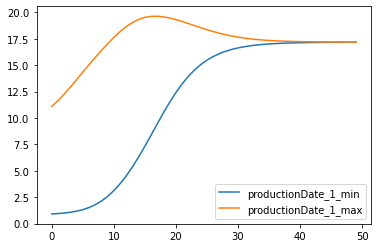

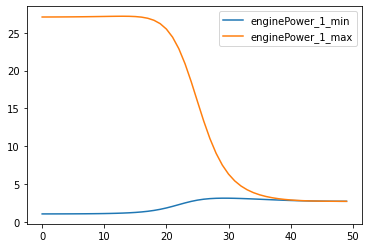

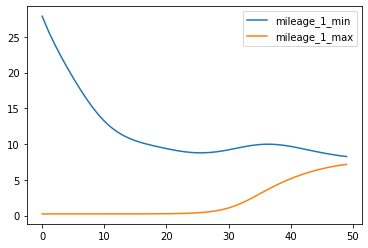

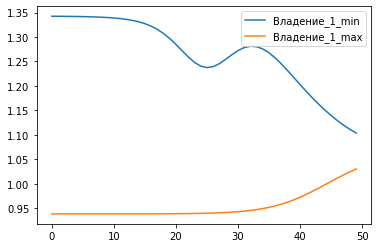

,productionDate_1_adder,productionDate_1_min,productionDate_1_max,enginePower_1_adder,enginePower_1_min,enginePower_1_max,mileage_1_adder,mileage_1_min,mileage_1_max,Владение_1_adder,Владение_1_min,Владение_1_max
0,0.201100,0.920191,11.101431,0.023100,1.086467,27.071458,1.330000e+01,27.865930,0.230676,0.003500,1.342391,0.938587
1,0.254362,0.954876,11.641535,0.029218,1.087695,27.074141,1.682257e+01,25.808654,0.230722,0.004427,1.342303,0.938588
2,0.321732,1.004967,12.258971,0.036957,1.089257,27.077482,2.127812e+01,23.977295,0.230781,0.005600,1.342191,0.938590
3,0.406944,1.077047,12.933502,0.046745,1.091247,27.081625,2.691374e+01,22.303155,0.230855,0.007083,1.342048,0.938592
4,0.514725,1.179860,13.638606,0.059126,1.093789,27.086733,3.404199e+01,20.735295,0.230949,0.008958,1.341864,0.938594
5,0.651053,1.324416,14.349727,0.074785,1.097041,27.092980,4.305819e+01,19.244558,0.231069,0.011331,1.341627,0.938597
6,0.823487,1.523640,15.050575,0.094593,1.101214,27.100541,5.446237e+01,17.824519,0.231221,0.014332,1.341320,0.938600
7,1.041592,1.791422,15.733564,0.119646,1.106586,27.109561,6.888701e+01,16.487749,0.231416,0.018128,1.340922,0.938605
8,1.317464,2.141161,16.395256,0.151335,1.113529,27.120100,8.713210e+01,15.257623,0.231665,0.022929,1.340401,0.938610
9,1.666401,2.584190,17.030682,0.191416,1.122546,27.132041,1.102095e+02,14.158229,0.231984,0.029002,1.339718,0.938618


In [40]:
# Calculate best distribution parameters
columns = ['productionDate', 'enginePower', 'mileage', 'Владение']
calc_anova_optimum_distribution(df, columns)[1]

In [41]:
# Form -1 degree features
distr_params = { 'enginePower_1': ('_max', 0.489939655109564),
                 'mileage_1': ('_min', 6.270772e+04),
                 'productionDate_1': ('_max', 10.917066308480281),
                 'Владение_1': ('_min', 6.447245)}
create_degree_1_features(df, distr_params)

# Additional -1 degree feature with second extremum parameters
df['enginePower_dup_1'] = 1 / (df['enginePower'] - df['enginePower'].min() + 21.027888)

## Correlation analysis

In [42]:
# Calculate correlation matrix
corr_table = df.loc[df[TRAIN] == 1].drop(TRAIN, axis=1).corr()
corr_table

,numberOfDoors,productionDate,engineDisplacement,enginePower,mileage,Владельцы,Владение,price,xDrive,sDrive,s_index,L_index,M_index,RANDOM,Владение_NaN,Владельцы_dup,enginePower_1,mileage_1,productionDate_1,Владение_1,enginePower_dup_1
numberOfDoors,1.000000,0.156074,0.103938,0.105585,-0.028231,-0.124154,0.005630,0.102993,-0.112628,0.040675,0.114279,-0.085639,0.046471,0.008178,0.007440,-0.124154,-0.012476,0.010403,0.124376,-0.015057,-0.137784
productionDate,0.156074,1.000000,-0.069979,0.228062,-0.765204,-0.536287,-0.220443,0.670576,-0.066302,0.059065,-0.054629,0.060519,0.118853,-0.000539,-0.003255,-0.536287,0.065312,0.660849,0.929063,0.084556,-0.314931
engineDisplacement,0.103938,-0.069979,1.000000,0.848820,0.026487,0.078971,0.139564,0.169965,0.007916,-0.061703,0.095986,0.245031,0.077886,0.013105,-0.001164,0.078971,0.101925,-0.040409,-0.122493,-0.091957,-0.665012
enginePower,0.105585,0.228062,0.848820,1.000000,-0.231601,-0.085700,0.052604,0.407139,-0.007604,-0.046197,0.067414,0.212947,0.200609,0.005368,-0.000680,-0.085700,0.197662,0.179201,0.164710,-0.057758,-0.741875
mileage,-0.028231,-0.765204,0.026487,-0.231601,1.000000,0.495950,0.131237,-0.637335,0.072494,-0.057315,0.062661,-0.059406,-0.114631,-0.003776,0.011838,0.495950,-0.066762,-0.843000,-0.774165,-0.063705,0.197835
Владельцы,-0.124154,-0.536287,0.078971,-0.085700,0.495950,1.000000,-0.114640,-0.558401,0.091037,-0.074003,0.066654,-0.029661,-0.115079,-0.014947,0.010167,1.000000,-0.061910,-0.569204,-0.629672,0.100203,0.121951
Владение,0.005630,-0.220443,0.139564,0.052604,0.131237,-0.114640,1.000000,-0.207998,0.004602,-0.019331,-0.003802,0.011258,-0.024301,-0.028245,NaN,-0.114640,-0.030606,-0.188841,-0.272480,-0.719925,-0.036302
price,0.102993,0.670576,0.169965,0.407139,-0.637335,-0.558401,-0.207998,1.000000,-0.090671,0.015624,-0.057401,0.100995,0.299745,0.000144,0.008976,-0.558401,0.211115,0.774020,0.800022,0.164565,-0.344950
xDrive,-0.112628,-0.066302,0.007916,-0.007604,0.072494,0.091037,0.004602,-0.090671,1.000000,-0.007171,-0.021359,-0.031249,-0.017495,0.017267,0.005978,0.091037,-0.007409,-0.087059,-0.095877,-0.001267,-0.051752
sDrive,0.040675,0.059065,-0.061703,-0.046197,-0.057315,-0.074003,-0.019331,0.015624,-0.007171,1.000000,-0.006454,-0.009442,-0.005286,0.000566,0.013415,-0.074003,-0.002499,0.076510,0.081388,0.009390,0.053848


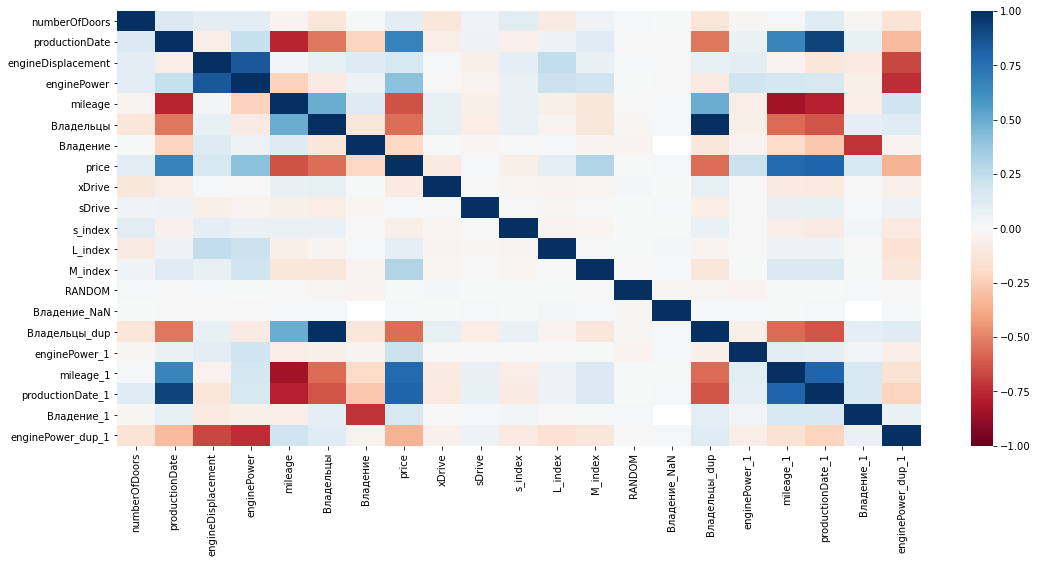

In [43]:
# Show correlation matrix
plt.subplots(figsize=(18, 8))
sns.heatmap(corr_table, vmin=-1, vmax=1, cmap="RdBu");

In [44]:
# Sort absolute correlation values with target variable
corr_table[TARGET].abs().sort_values(ascending=False)

price                 1.000000
productionDate_1      0.800022
mileage_1             0.774020
productionDate        0.670576
mileage               0.637335
Владельцы_dup         0.558401
Владельцы             0.558401
enginePower           0.407139
enginePower_dup_1     0.344950
M_index               0.299745
enginePower_1         0.211115
Владение              0.207998
engineDisplacement    0.169965
Владение_1            0.164565
numberOfDoors         0.102993
L_index               0.100995
xDrive                0.090671
s_index               0.057401
sDrive                0.015624
Владение_NaN          0.008976
RANDOM                0.000144
Name: price, dtype: float64

## Significance analysis of quantity and ordinal features
### Analysis of variance (ANOVA)

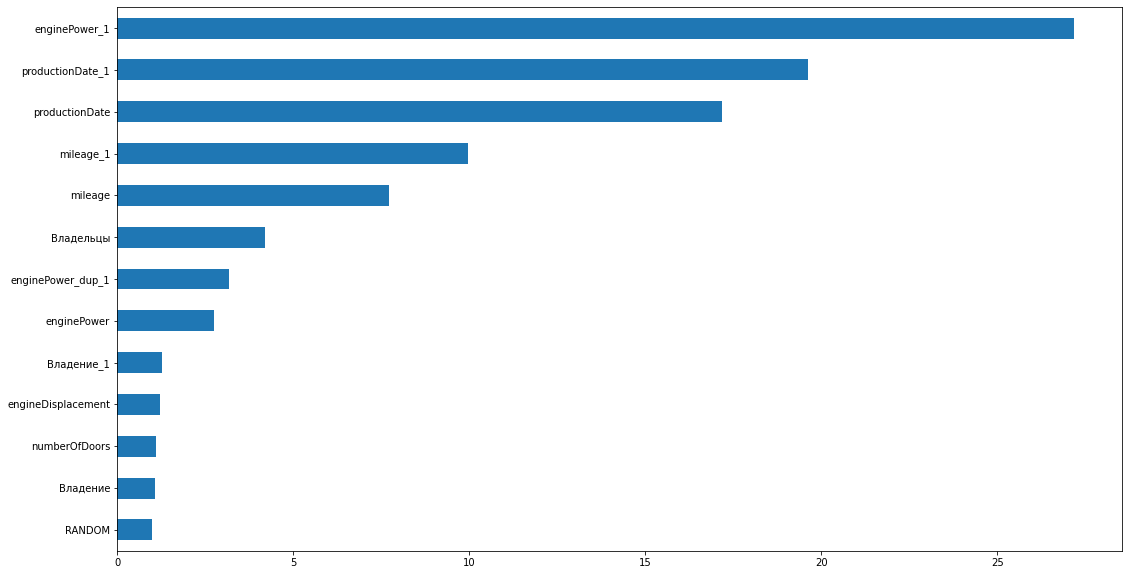

In [45]:
# Do ANOVA analysis
anova_analysis(df).sort_values().plot(figsize=(18, 10), kind='barh');

## Significance analysis of categorical features
### Student's t-test

С помощью теста Стьюдента проверим есть ли статистически значимая разница в распределении целевой переменной для разных значений категориальных признаков. Проверяем нулевую гипотезу о том, что распределения целевой переменной по различным значениям категориальных переменных неразличимы.

In [46]:
def hypothesis_testing(df):
    """Hypothesis testing of significance analysis"""
    NUM_OF_VALS = 10

    # Find not significant features
    mask = {}
    top_values = {}
    not_signif_columns = []
    for column in categ_cols:
        # Find top NUM_OF_VALS values
        top_values[column] = categorical_unique[column].index[:NUM_OF_VALS]

        # Find boolean masks
        mask[column] = {}
        for value in top_values[column]:
            if column in categ_multi_cols:
                mask[column][value] = (df[column].str.contains('(?:^|\|)'+value+'(?:$|\|)')) & (df[TARGET].notna())
            else:
                mask[column][value] = (df[column] == value) & (df[TARGET].notna())

        # Student t-test for value combinations
        combs = list(combinations(top_values[column], 2))
        for comb in combs:
            if ttest_ind(df.loc[mask[column][comb[0]], TARGET], 
                         df.loc[mask[column][comb[1]], TARGET]) \
                            .pvalue <= 0.05/len(combs): # Bonferroni correction
                break
        else:
            not_signif_columns.append(column)

    # Show result
    if len(not_signif_columns):
        print('Statistically significant differences have NOT been found for features:')
        for column in not_signif_columns:
            print(f"'{column}'")
    else:
        print('All categorical features have statistically significant difference with target')
        
    return (top_values, mask)


def boxplot_significance(df, top_values, mask):
    """Show boxplots of features to view significance"""
    # Create figure with [rows x cols] graphs
    rows = len(categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(categ_cols):
        if rows == 1:
            axs.boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_values[column], rotation=5)
            axs.set_ylabel(TARGET)
        else:
            axs[i].boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_values[column], rotation=5)
            axs[i].set_ylabel(TARGET)

/opt/conda/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Statistically significant differences have NOT been found for features:
'sDrive'
'Владение_NaN'


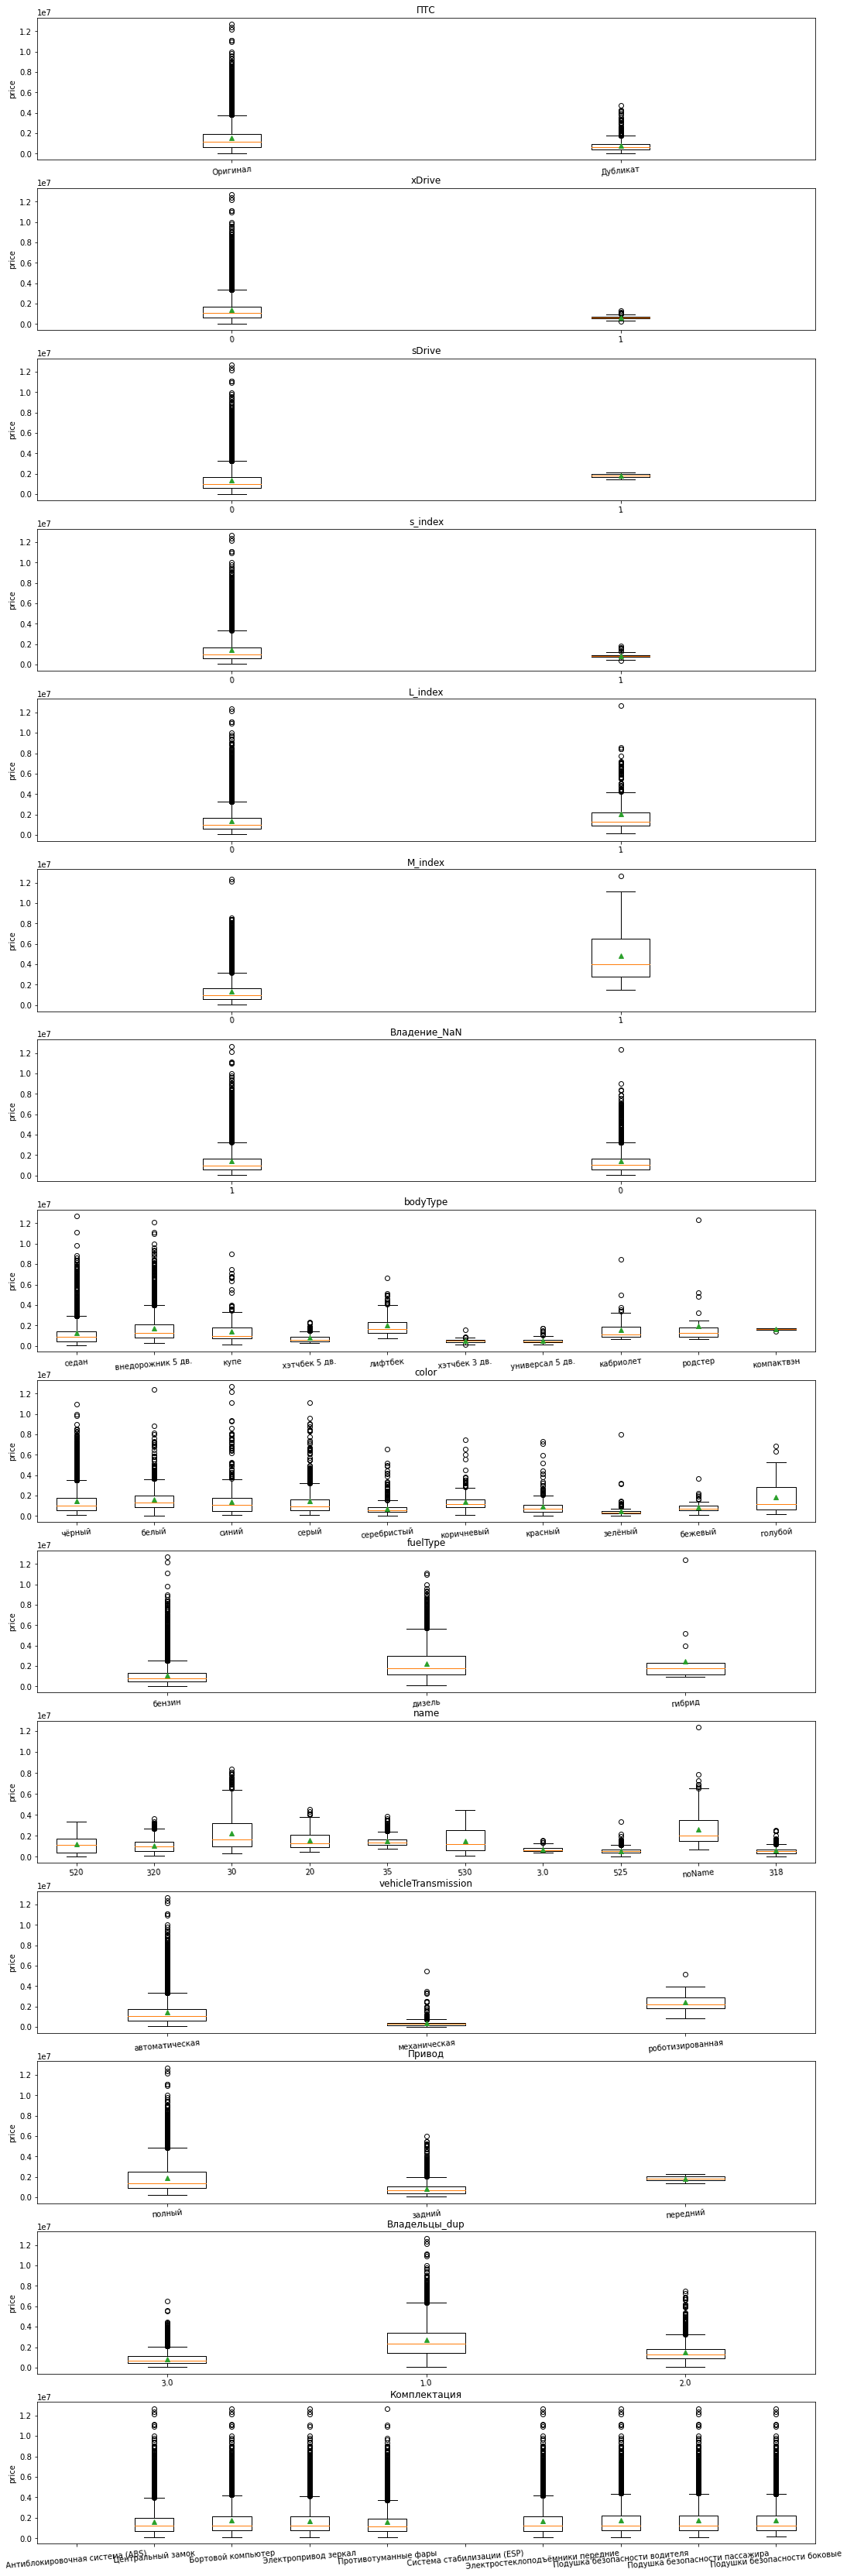

In [47]:
# Do hypothesis testing and show boxplots of significant features
top_values, mask = hypothesis_testing(df.loc[df[TRAIN] == 1])
boxplot_significance(df.loc[df[TRAIN] == 1], top_values, mask)

### Mutual information

In [48]:
def mutual_information_analysis(df):
    """Calculate and show significance of categorical features based on mutual information analysis"""
    columns = categ_bin_cols + categ_many_cols
    df_temp = df[columns + [TARGET]].dropna()
    pd.Series(mutual_info_classif(OrdinalEncoder().fit_transform(df_temp[columns]), df_temp[TARGET], discrete_features=True), index=columns).sort_values().plot(figsize=(18, 6), kind='barh');

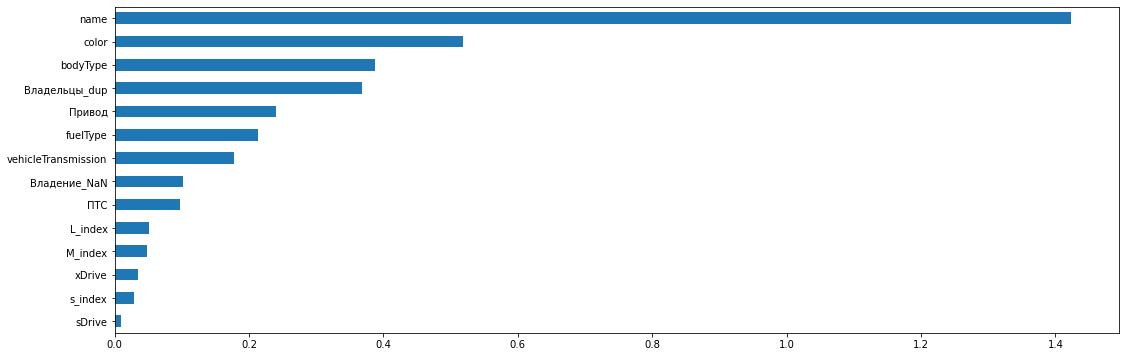

In [49]:
# Do mutual information analysis
mutual_information_analysis(df.loc[df[TRAIN] == 1])

**- Delete proportional and highly correlated features, and also features with week correlation with target variable**

**- Delete features without statistically significant difference**

In [50]:
# Define features to delete
cols = []

# Deleting
df.drop(columns=[col for col in cols if col in df.columns], inplace=True)

# Update feature list
categ_bin_cols = [col for col in categ_bin_cols if col in df.columns]
categ_many_cols = [col for col in categ_many_cols if col in df.columns]
categ_multi_cols = [col for col in categ_multi_cols if col in df.columns]
categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
quantity_cols = [col for col in quantity_cols if col in df.columns]
quantity_categ_cols = [col for col in quantity_categ_cols if col in df.columns]
ordinal_cols = [col for col in ordinal_cols if col in df.columns]

## Missing values handling

In [51]:
def fill_missing_values(df):
    """Fill missing values (NaNs) for columns"""
    # Drop rows with missing values of target variable
    nan_number = df[TARGET].isna().sum()
    if nan_number:
        df.dropna(subset=[TARGET], inplace=True)
        print(f"{nan_number} rows have been dropped in order to delete missed target values")

    # Drop rows with missing values
    pass
    
    # Fill missing values
    for column in quantity_cols + ordinal_cols + categ_cols:
        # Calculate number of replaced values
        nan_number = df[column].isna().sum()
        
        if nan_number:
            # For individual columns
            if column == 'column_name':
                value = 2
                
            elif column == 'column_2':
                values = df.groupby('categ_column')['column_2'].mean().round()
                df['zzz'] = df['categ_column'].map(values)
                idx = df['column_2'].isna()
                df.loc[idx, 'column_2'] = df.loc[idx, 'zzz']
                df.drop('zzz', axis=1, inplace=True)
                continue

            # For groups of columns
            elif column in quantity_cols:
                value = df[column].mean()

            elif column in ordinal_cols:
                value = df[column].mode()[0]

            elif column in categ_bin_cols:
                value = categorical_unique[column].index[0]

            elif column in categ_many_cols:
                value = categorical_unique[column].index[0]

            elif column in categ_multi_cols:
                values_num = round(df.loc[df[column].notna(), column].apply(lambda x: len(x.split('|'))).mean())
                value = '|'.join(categorical_unique[column].index[:values_num])

            # Replace
            df[column].fillna(value, inplace=True)
            
            # Show number of replaced values in column
            print(f"{str(nan_number).rjust(6)} NaN have been replaced in column '{column}'")

In [52]:
# Fill missing values
fill_missing_values(df)

  7407 NaN have been replaced in column 'Владение'
  7407 NaN have been replaced in column 'Владение_1'


## Polynomial features generation

In [53]:
def generate_polynomials(df, columns, collinear_sens=False):
    """Generate polynomial features
    
    collinear_sens is parameter for ML model collinearity sensitivity.
    It's either True or False. It should be True for OLS method for example.
    """
    global quantity_cols
    
    # Generate polynomials for quantity_cols
    pf = PolynomialFeatures(2, interaction_only=collinear_sens)
    pf_df = pf.fit_transform(df[columns])
    pf_cols = pf.get_feature_names(input_features=columns)
    
    # Find columns of ones
    columns_1 = []
    for column in columns:
        columns_1.append(column + ' ' + column + MINUS_ONE_SUFFIX)
        columns_1.append(column + MINUS_ONE_SUFFIX + ' ' + column)
    columns_1 = [x for x in columns_1 if x in pf_cols]
    
    # Join dataframe and drop duplicated columns and ones
    pf_df = pd.DataFrame(pf_df, columns=pf_cols, index=df.index).drop(columns=columns+['1']+columns_1)
    df = pd.concat([df, pf_df], axis=1)
    
    # Add columns to quantity_cols list
    quantity_cols = list(set(quantity_cols + pf_cols) - set(columns_1 + ['1']))
    
    return df

In [54]:
columns = list(set(quantity_cols) - set([
    RANDOM, 'numberOfDoors', 'engineDisplacement', 'Владельцы',
]))

# Generate polynomial features
df = generate_polynomials(df, columns, collinear_sens=False)

## Dummies generation

In [55]:
def generate_dummies(df, collinear_sens):
    """Dummies generation from categorical features
    
    collinear_sens is ML model collinearity sensitivity. It's either True or False.
    """
    # Generate dummies for categ_multi_cols
    for column in categ_multi_cols:
        df = pd.concat([df, df[column].str.get_dummies()], axis=1)
    df.drop(categ_multi_cols, axis=1, inplace=True)

    # Generate dummies for categ_bin_cols and categ_many_cols
    df = pd.get_dummies(df, columns=categ_bin_cols+categ_many_cols, drop_first=collinear_sens)
    
    return df

In [56]:
# Generate dummies
df = generate_dummies(df, collinear_sens=False)

# Model implementation

## Data preparing

In [58]:
# Prepare data
df, sample_submission = collect_data()
format_features(df)
create_new_features(df)
delete_useless_features(df)
declare_features_type()
delete_outliers(df, inplace=DROP_AVAL)
fill_missing_values(df)
columns = list(set(quantity_cols) - set([RANDOM, 'numberOfDoors', 'engineDisplacement', 'Владельцы']))
df = generate_polynomials(df, columns, collinear_sens=False)
df = generate_dummies(df, collinear_sens=False)

df_temp = df.copy()
df_temp

   344 outliers are in column 'engineDisplacement'
   523 outliers are in column 'enginePower'
  1026 outliers are in column 'enginePower_1'
   417 outliers are in column 'enginePower_dup_1'
   283 outliers are in column 'mileage'
   906 outliers are in column 'mileage_1'
   730 outliers are in column 'numberOfDoors'
   482 outliers are in column 'productionDate'
   119 outliers are in column 'Владение'
   176 outliers are in column 'Владение_1'
  7407 NaN have been replaced in column 'Владение'
  7407 NaN have been replaced in column 'Владение_1'


,numberOfDoors,productionDate,engineDisplacement,enginePower,mileage,Владельцы,Владение,TRAIN,price,RANDOM,enginePower_1,mileage_1,productionDate_1,Владение_1,enginePower_dup_1,enginePower^2,enginePower Владение_1,enginePower mileage,enginePower productionDate_1,enginePower enginePower_dup_1,...,name_740,name_745,name_750,name_760,name_840,name_850,name_94Ah,name_ActiveHybrid,name_Actve Hybr 7,name_Competition,name_noName,vehicleTransmission_автоматическая,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Привод_задний,Привод_передний,Привод_полный,Владельцы_dup_1.0,Владельцы_dup_2.0,Владельцы_dup_3.0
0,4.0,2017.0,2.0,190.0,158836.0,1.0,45.42734,0,0.0,89250,0.002296,0.000005,0.077417,0.032808,0.006060,36100.0,6.233496,30178840.0,14.709222,1.151321,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
1,4.0,2019.0,2.0,150.0,10.0,1.0,45.42734,0,0.0,773956,0.002103,0.000016,0.091600,0.032808,0.007998,22500.0,4.921181,1500.0,13.739955,1.199732,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,4.0,2012.0,4.4,407.0,120000.0,2.0,86.00000,0,0.0,654571,0.004577,0.000005,0.055813,0.010935,0.002618,165649.0,4.450653,48840000.0,22.715772,1.065367,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
3,5.0,2015.0,3.0,249.0,111466.0,2.0,45.42734,0,0.0,438878,0.002656,0.000006,0.067037,0.032808,0.004464,62001.0,8.169160,27755034.0,16.692290,1.111469,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
4,5.0,2019.0,3.0,381.0,11891.0,1.0,45.42734,0,0.0,433015,0.004090,0.000013,0.091600,0.032808,0.002809,145161.0,12.499799,4530471.0,34.899486,1.070141,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12248,5.0,2007.0,3.0,272.0,211000.0,3.0,45.42734,1,950000.0,987700,0.002829,0.000004,0.043636,0.032808,0.004048,73984.0,8.923741,57392000.0,11.868884,1.101090,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
12249,5.0,2006.0,4.8,355.0,200000.0,3.0,46.00000,1,900000.0,66312,0.003697,0.000004,0.041811,0.019437,0.003030,126025.0,6.900272,71000000.0,14.842958,1.075667,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
12250,5.0,2008.0,3.0,272.0,172000.0,3.0,45.42734,1,1100000.0,247706,0.002829,0.000004,0.045627,0.032808,0.004048,73984.0,8.923741,46784000.0,12.410420,1.101090,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
12251,4.0,2007.0,4.4,407.0,110000.0,2.0,45.42734,1,1050000.0,317840,0.004577,0.000006,0.043636,0.032808,0.002618,165649.0,13.352804,44770000.0,17.759690,1.065367,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [59]:
df = df_temp.copy()

## Data splitting & Data scaling

In [60]:
def split_dataframe(data, test_size, stratify=True, normalize=True):
    """Split dataframe to: X, X_train, X_test, y, y_train, y_test"""
    # Split data: Х - features, у - target variable
    X = data.loc[data[TRAIN] == 1].drop([TRAIN, TARGET], axis=1)
    y = data.loc[data[TRAIN] == 1, TARGET].values

    # Split data on train and test parts
    strat = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=strat, shuffle=True, random_state=RANDOM_SEED
    )

    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    return (X, X_train, X_test, y, y_train, y_test)

In [61]:
# Data splitting
X, X_train, X_test, y, y_train, y_test = split_dataframe(df, test_size=0.2, stratify=False)
print('Shapes:', X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)

Shapes: (8325, 350) (6660, 350) (1665, 350) (8325,) (6660,) (1665,)


## Features tuning

In [62]:
def train_test_vs_sample_value(model, df, cv_top, cv_bottom):
    """Calculate train and test scores versus sample value.
    
    It is in order to detect high bias or high variance.
    It also helps to find optimum sample value to fit model for tuning.
    """
    # Separate train data
    X = df.loc[df[TRAIN] == 1].drop([TRAIN, TARGET], axis=1).values
    y = df.loc[df[TRAIN] == 1, TARGET].values
    
    # Cycle over top CV folds
    score = []
    scaler = StandardScaler()
    for i, (train_index_t, test_index_t) in enumerate(cv_top.split(X, y)):
        # Top splitting on train and test parts. Standardize.
        X_train_t, X_test_t = X[train_index_t, :], X[test_index_t, :]
        y_train_t, y_test_t = y[train_index_t], y[test_index_t]
        X_test_t = scaler.fit_transform(X_test_t)

        # Cycle over train size
        sample_val = []
        score_train = []
        score_test = []
        train_index_b = np.array([]).astype(int)
        for j, (_, test_index_b) in enumerate(cv_bottom.split(X_train_t, y_train_t)):
            # Expand train indices
            train_index_b = np.concatenate([train_index_b, test_index_b])
            
            # Bottom splitting on train and test parts. Standardize.
            X_train_b = X_train_t[train_index_b, :]
            y_train_b = y_train_t[train_index_b]
            X_train_b = scaler.fit_transform(X_train_b)
            sample_val.append(X_train_b.shape[0])
            
            # Print status
            print(f'Process: top_fold_number = {i+1};', end=' ')
            print(f'bottom_fold_number = {j+1}; train_size = {X_train_b.shape[0]}')
            
            # Learn model
            model.fit(X_train_b, y_train_b)
            
            # Test model
            if PROBLEM == 'Regression':
                if METRIC == 'MAPE':
                    score_train.append(np.mean(np.abs((y_train_b - model.predict(X_train_b)) / y_train_b)))
                    score_test.append(np.mean(np.abs((y_test_t - model.predict(X_test_t)) / y_test_t)))
                else:
                    raise ValueError
            elif PROBLEM == 'Classification':
                if METRIC == 'ROC AUC':
                    score_train.append(roc_auc_score(y_train_b, model.predict_proba(X_train_b)[:,1]))
                    score_test.append(roc_auc_score(y_test_t, model.predict_proba(X_test_t)[:,1]))
                else:
                    raise ValueError
            else:
                raise ValueError
            
        # Append fold result
        score.append({'sample value': sample_val, METRIC+' train': score_train, METRIC+' test': score_test})

    # Average result
    length = len(score[0]['sample value'])
    sample_val = [0]*length
    score_train = [0]*length
    score_test = [0]*length
    for scr in score:
        for i in range(length):
            sample_val[i] += scr['sample value'][i]
            score_train[i] += scr[METRIC+' train'][i]
            score_test[i] += scr[METRIC+' test'][i]
    for i in range(length):
        sample_val[i] /= cv_top.get_n_splits()
        score_train[i] /= cv_top.get_n_splits()
        score_test[i] /= cv_top.get_n_splits()
    
    return pd.DataFrame.from_dict({'sample value': sample_val, METRIC+' train': score_train, METRIC+' test': score_test})


def find_usefull_useless_feature(model, data, cv, greater_score_is_better, usefull_cols=None):
    """Find the most usefull or useless feature.
    
    Find the most usefull feature to add if 'usefull_cols' is a list.
    Find the most useless feature to drop if 'usefull_cols' is None.
    """
    # Separate train data
    X = data.loc[data[TRAIN] == 1].drop([TARGET, TRAIN], axis=1)
    y = data.loc[data[TRAIN] == 1, TARGET].values
    
    # Cycle over folds
    # inverse order of train and test indices
    f_train_score = defaultdict(np.float64)
    f_test_score = defaultdict(np.float64)
    scaler = StandardScaler()
    for i, (test_index, train_index) in enumerate(cv.split(X.values, y)):
        # Split on train and test
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        # Standardize train and test parts
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
        
        # Determine features list
        if usefull_cols is not None:
            columns = [col for col in X_train.columns if col not in usefull_cols]
        else:
            columns = X_train.columns # [0:110]
        
        # Cycle over features
        for j, column in enumerate(columns):
            # Define train and test data
            if usefull_cols is not None:
                cols = usefull_cols + [column]
                X_train_temp = X_train[cols]
                X_test_temp = X_test[cols]
            else:
                X_train_temp = X_train.drop(column, axis=1)
                X_test_temp = X_test.drop(column, axis=1)

            # Learn model
            model.fit(X_train_temp, y_train)

            # Test model and update dicts
            if PROBLEM == 'Regression':
                if METRIC == 'MAPE':
                    f_train_score[column] += np.mean(np.abs((y_train - model.predict(X_train_temp)) / y_train))
                    f_test_score[column] += np.mean(np.abs((y_test - model.predict(X_test_temp)) / y_test))
                else:
                    raise ValueError
            elif PROBLEM == 'Classification':
                if METRIC == 'ROC AUC':
                    f_train_score[column] += roc_auc_score(y_train, model.predict_proba(X_train_temp)[:,1])
                    f_test_score[column] += roc_auc_score(y_test, model.predict_proba(X_test_temp)[:,1])
                else:
                    raise ValueError
            else:
                raise ValueError

            # Print status for every feature
            print(f'Completed: fold_number = {i+1}; feature_number = {j+1}; mean_test_score[{column}] = {f_test_score[column] / (i+1)}')
        
        # Print status for every fold
        if greater_score_is_better:
            feature = max(f_test_score, key=f_test_score.get)
        else:
            feature = min(f_test_score, key=f_test_score.get)
        print(feature, f_test_score[feature] / (i+1))

    # Average result
    for column in f_train_score.keys():
        f_train_score[column] /= cv.get_n_splits()
        f_test_score[column] /= cv.get_n_splits()
    
    # Form result DataFrame
    result = pd.DataFrame.from_dict([f_train_score, f_test_score]).transpose().reset_index()
    result.columns = ['feature', METRIC+' train', METRIC+' test']
    
    return result.sort_values(METRIC+' test', ascending=not greater_score_is_better, ignore_index=True)


def find_several_usefull_useless_features(
    model, data, features_num, cv, greater_score_is_better, usefull_cols=None
):
    """Find several usefull of useless features at a time.
    
    Find the most usefull features to add if 'usefull_cols' is a list.
    Find the most useless features to drop if 'usefull_cols' is None.
    """
    # Find exact features_num
    if usefull_cols is not None:
        # 2 in formula means TRAIN and TARGET columns
        features_num = min(features_num, data.shape[1] - len(usefull_cols) - 2)
    else:
        features_num = min(features_num, data.shape[1] - 2)

    # Find features
    useless_cols = []
    features_score = pd.DataFrame(columns=['feature', METRIC+' train', METRIC+' test'])
    for i in range(features_num):
        if usefull_cols is not None:
            # Find usefull feature and append it
            df_score = find_usefull_useless_feature(
                model, data=data, cv=cv, greater_score_is_better=greater_score_is_better,
                usefull_cols=usefull_cols
            )
            usefull_cols.append(df_score.iloc[0, 0])
        else:
            # Find useless feature and drop it
            df_score = find_usefull_useless_feature(
                model, data=data.drop(useless_cols, axis=1), cv=cv,
                greater_score_is_better=greater_score_is_better
            )
            useless_cols.append(df_score.iloc[0, 0])

        # Print and save an intermediate result
        features_score = features_score.append(df_score.iloc[0], ignore_index=True)
        features_score.to_csv('train_test_score_vs_feature_number_new.csv', index=False)
        print('Feature number =', i+1)
        print(features_score)
        
    return features_score

   sample value  MAPE train  MAPE test
0         313.0    0.102024   0.203522


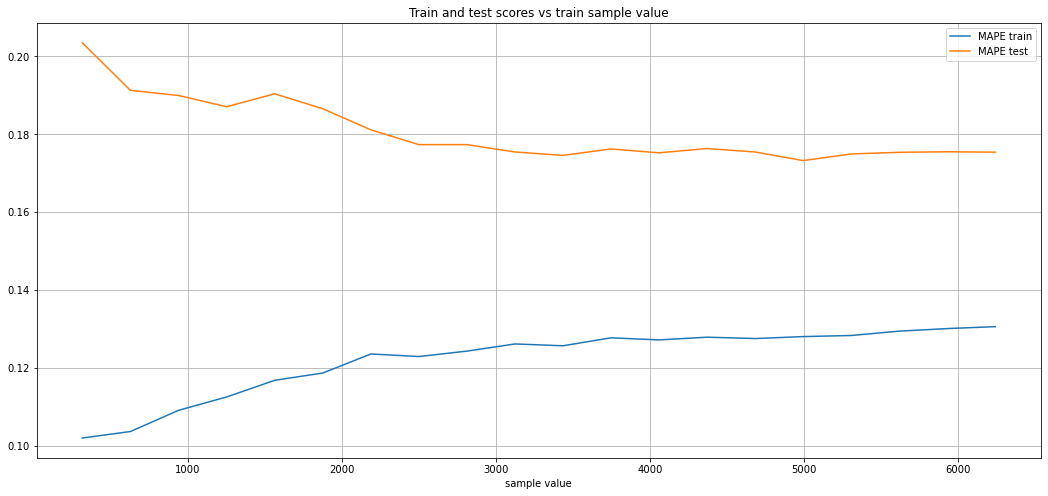

In [64]:
usefull_cols_1 = [
    # RandomForestRegressor, iteration 1
#     'productionDate_1', 'enginePower', 'fuelType_бензин', 'numberOfDoors',
    
    # RandomForestRegressor, iteration 2
    'productionDate_1', 'enginePower^2', 'fuelType_бензин',
    'numberOfDoors', 'mileage_1 productionDate_1',
    'productionDate_1 enginePower', 'name_noName',
    'bodyType_внедорожник 5 дв.',
]

# Compute train and test scores versus sample value to define
# whether the model has high bias or high variance
# and find optimum train-test sample proportion to tune features
# score = train_test_vs_sample_value(
#     model=RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=10,
#                                 max_features='log2', random_state=RANDOM_SEED,
#                                 n_jobs=-1, verbose=0),
#     df=df[usefull_cols_1 + [TARGET, TRAIN]],
#     cv_top=KFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED),
#     cv_bottom=KFold(n_splits=20, shuffle=True, random_state=RANDOM_SEED),
# )

# Update sample value score dataframe
score = pd.read_csv(PATH_KERNEL+'train_test_score_vs_sample_value.csv')
score.to_csv('train_test_score_vs_sample_value.csv', index=False)

# Plot train and test scores versus sample value
score.plot(x='sample value', figsize=(18, 8), grid=True, title='Train and test scores vs train sample value')
print(score.nlargest(1, METRIC+' test'))

The sample value of 2500 for train set is a good choice to find usefull features

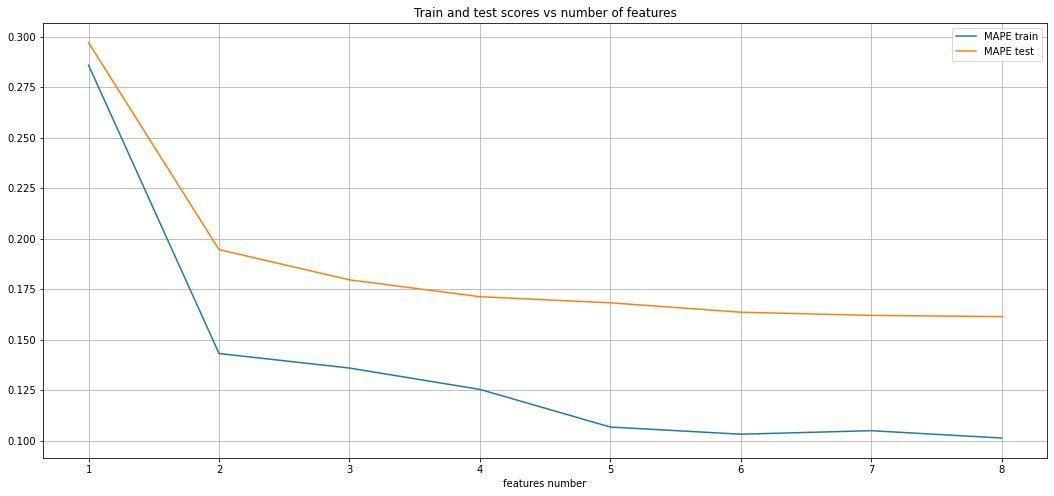

In [67]:
# Already found usefull features
usefull_cols_1 = [
    # RandomForestRegressor, iteration 1
#     'productionDate_1', 'enginePower', 'fuelType_бензин', 'numberOfDoors',

    # RandomForestRegressor, iteration 2
    'productionDate_1', 'enginePower^2', 'fuelType_бензин',
    'numberOfDoors',
    'productionDate_1 mileage_1',
    'productionDate_1 enginePower', 'name_noName',
    'bodyType_внедорожник 5 дв.',
]
# Number of features to find next
features_num = 8

# Sample value to use
sample_value = 2500

# Compute next usefull features
n_splits = round(df.shape[0] / sample_value)
n_splits = n_splits if n_splits >= 2 else 2
# find_several_usefull_useless_features(
#     model=RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=10,
#                                 max_features='log2', random_state=RANDOM_SEED,
#                                 n_jobs=-1, verbose=0),
#     data=df,
#     features_num=features_num,
#     cv=KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED),
#     greater_score_is_better=False,
#     usefull_cols=usefull_cols_1,
# )

# Update features score dataframe
# First time
# features_score = pd.read_csv(PATH_WORKING+'train_test_score_vs_feature_number_new.csv')
# features_score.to_csv('train_test_score_vs_feature_number.csv', index=False)
# Next times
# features_score = pd.read_csv(PATH_KERNEL+'train_test_score_vs_feature_number.csv')
# features_score_new = pd.read_csv(PATH_WORKING+'train_test_score_vs_feature_number_new.csv')
# features_score = features_score.append(features_score_new, ignore_index=True)
# features_score.to_csv('train_test_score_vs_feature_number.csv', index=False)
# Done
features_score = pd.read_csv(PATH_KERNEL+'train_test_score_vs_feature_number.csv')
features_score.to_csv('train_test_score_vs_feature_number.csv', index=False)

# Plot train and test scores versus number of features
features_score['features number'] = features_score.index + 1
features_score.plot(x='features number', figsize=(18, 8), grid=True,
    title='Train and test scores vs number of features');#, ylim=(0.735, 0.738));

## Hyperparameters tuning

**Scorers**

In [68]:
# Create MAPE scorer
def mape_score_func(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))
mape_scorer = make_scorer(mape_score_func, greater_is_better=False)

**Tuning**

In [73]:
# Define model
model = RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=10,
                            max_features='log2', random_state=RANDOM_SEED,
                            n_jobs=-1, verbose=0)

# Define parameters grid
parameters = {
    'criterion': ['mse', 'mae'],
    'max_depth': np.geomspace(start=2, stop=20, num=5).astype(int),
    'max_features': ['auto', 'sqrt', 'log2', 1/3],
}

# Define cross validation
cv = KFold(n_splits=4, random_state=RANDOM_SEED)

# Define scorer
scorer= mape_scorer

# # Define and fit grid search
# grs = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer,
#                      cv=cv, n_jobs=-1, verbose=2)
# grs.fit(X[usefull_cols_1], y)

# # Print result
# print('cv_results_:', grs.cv_results_)
# print()
# print('best_estimator_:', grs.best_estimator_)
# print()
# print('best_score_:', grs.best_score_)
# print()
# print('best_params_:', grs.best_params_)

## Model testing
**Score evaluation**

In [75]:
usefull_cols_1 = [
    'productionDate_1', 'enginePower^2', 'fuelType_бензин',
    'numberOfDoors', 'productionDate_1 mileage_1',
    'enginePower productionDate_1', 'name_noName',
    'bodyType_внедорожник 5 дв.',
]

# Define model
model = RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=10,
                            max_features='sqrt', random_state=RANDOM_SEED,
                            n_jobs=-1, verbose=1)

# Define cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)

# Evaluate model
score = cross_val_score(
    model, X[usefull_cols_1], y, scoring=mape_scorer, cv=cv, n_jobs=-1, verbose=1
)
print('Shapes:', X[usefull_cols_1].shape, y.shape)
print('Mean', METRIC, 'score =', np.mean(score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Shapes: (8325, 8) (8325,)
Mean MAPE score = -0.1438122285478046


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


**Model characteristics**

In [76]:
# Learn model on 100% of train data
model.fit(X[usefull_cols_1], y)

# View model characteristics
print('base_estimator_:', model.base_estimator_)
print()
print('estimators_:', model.estimators_)
print()
print('feature_importances_:', model.feature_importances_)
print()
print('n_features_:', model.n_features_)
print()
print('n_outputs_:', model.n_outputs_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


base_estimator_: DecisionTreeRegressor()

estimators_: [DecisionTreeRegressor(criterion='mae', max_depth=10, max_features='sqrt',
                      random_state=1608637542), DecisionTreeRegressor(criterion='mae', max_depth=10, max_features='sqrt',
                      random_state=1273642419), DecisionTreeRegressor(criterion='mae', max_depth=10, max_features='sqrt',
                      random_state=1935803228), DecisionTreeRegressor(criterion='mae', max_depth=10, max_features='sqrt',
                      random_state=787846414), DecisionTreeRegressor(criterion='mae', max_depth=10, max_features='sqrt',
                      random_state=996406378), DecisionTreeRegressor(criterion='mae', max_depth=10, max_features='sqrt',
                      random_state=1201263687), DecisionTreeRegressor(criterion='mae', max_depth=10, max_features='sqrt',
                      random_state=423734972), DecisionTreeRegressor(criterion='mae', max_depth=10, max_features='sqrt',
                   

## Stacking

In [86]:
def compute_meta_feature(estimator, X_train, X_test, y_train, cv):
    """
    Эта функция подсчитывает признаки для мета-классификатора.
    
    :arg estimator: модель регрессии
    :args X_train, y_train: обучающая выборка
    :arg X_test: признаки тестовой выборки
    :arg cv: класс, генерирующий фолды (KFold)
    
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок
    """
    X_meta_train = np.zeros(len(y_train), dtype=np.float32)

    for train_fold_index, predict_fold_index in cv.split(X_train, y_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_estimator = clone(estimator)
        folded_estimator.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_estimator.predict(X_fold_predict)
    
    meta_estimator = clone(estimator)
    meta_estimator.fit(X_train, y_train)
    
    X_meta_test = meta_estimator.predict(X_test)
    
    return X_meta_train, X_meta_test


def compute_meta_feature_mean(estimator, X_train, X_test, y_train, cv):
    """
    Эта функция подсчитывает признаки для мета-классификатора.
    
    :arg estimator: модель регрессии
    :args X_train, y_train: обучающая выборка
    :arg X_test: признаки тестовой выборки
    :arg cv: класс, генерирующий фолды (KFold)
    
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок
    """
    X_meta_train = np.zeros(len(X_train), dtype=np.float32)
    X_meta_test = np.zeros(len(X_test), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_estimator = clone(estimator)
        folded_estimator.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_estimator.predict(X_fold_predict)
        X_meta_test += folded_estimator.predict(X_test)

    X_meta_test /= cv.get_n_splits()

    return X_meta_train, X_meta_test


def generate_meta_features(estimators, X_train, X_test, y_train, cv):
    """Generate features for meta model"""
    features = [
        compute_meta_feature(estimator, X_train, X_test, y_train, cv)
            for estimator in tqdm(estimators)
    ]
    
    stacked_features_train = np.stack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.stack([
        features_test for features_train, features_test in features
    ]).T
    
    stacked_features_train = StandardScaler().fit_transform(stacked_features_train)
    stacked_features_test = StandardScaler().fit_transform(stacked_features_test)

    return stacked_features_train, stacked_features_test


def compute_metric(estimator, X_train, y_train, X_test, y_test):
    """Compute stack metric"""
    estimator.fit(X_train, y_train)
    score = np.mean(np.abs((y_test - estimator.predict(X_test)) / y_test))
    
    return score

In [87]:
usefull_cols_1 = [
    'productionDate_1', 'enginePower^2', 'fuelType_бензин',
    'numberOfDoors',
    'productionDate_1 mileage_1', 'productionDate_1 mileage_1',
    'name_noName', 'bodyType_внедорожник 5 дв.',
]

cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=10,
                          max_features='sqrt', random_state=RANDOM_SEED,
                          n_jobs=-1, verbose=0),
    GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_SEED),
], X_train[usefull_cols_1].values, X_test[usefull_cols_1].values, y_train, cv)

model = LinearRegression(n_jobs=-1)
compute_metric(model, stacked_features_train, y_train, stacked_features_test, y_test)

100%|██████████| 2/2 [01:05<00:00, 32.87s/it]


0.16407714728269815

In [88]:
X_train_ = df.loc[df[TRAIN] == 1, usefull_cols_1].values
y_train_ = df.loc[df[TRAIN] == 1, TARGET].values
X_test_ = df.loc[df[TRAIN] == 0, usefull_cols_1].values

cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=10,
                          max_features='sqrt', random_state=RANDOM_SEED,
                          n_jobs=-1, verbose=0),
    GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_SEED),
], X_train_, X_test_, y_train_, cv)

100%|██████████| 2/2 [00:59<00:00, 29.81s/it]


# Submission
**Learn model on 100% of train data**

In [89]:
# Create and learn model
model = LinearRegression(n_jobs=-1)
model.fit(stacked_features_train, y_train_)

# Predict target variable
predict_submission = model.predict(stacked_features_test)
predict_submission

array([1882713.62703215, 2143654.01137959, 1084085.71478518, ...,
        291365.04055786,  841621.03369212,  847864.6069658 ])

**Postprocess**

In [90]:
predict_submission_post = np.round(1.05 * predict_submission)
predict_submission_post

array([1976849., 2250837., 1138290., ...,  305933.,  883702.,  890258.])

**Write result to submission file**

In [91]:
sample_submission = pd.DataFrame()
sample_submission[IDENT] = df.loc[df[TRAIN] == 0].index
sample_submission[TARGET] = predict_submission_post
sample_submission.reset_index(drop=True, inplace=True)
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,id,price
0,0,1976849.0
1,1,2250837.0
2,2,1138290.0
3,3,2592957.0
4,4,6185835.0
...,...,...
3832,3832,856552.0
3833,3833,2858869.0
3834,3834,305933.0
3835,3835,883702.0
